# Fantapalla Forever Stats

In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
# Set the style globally
plt.style.use('default')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Exo 2'
rcParams['font.weight'] = '500'
#rcParams['font.monospace'] = 'Ubuntu Mono'
rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 16
rcParams['axes.labelweight'] = '500'
rcParams['axes.titleweight'] = '600'
rcParams['axes.titlesize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['legend.fontsize'] = 12
rcParams['figure.titlesize'] = 18


### Init dataframes #########################################################
Teams = {'luca' : ['XYZ', 'black'],
         'franky' : ['Mainz Na Gioia', 'r'],
         'emiliano' : ['I Diseredati', 'skyblue'],
         'nanni' : ['Palla Pazza', 'firebrick'],
         'enzo' : ['AS 800A', 'gold'],
         'pietro' : ['PDG 1908', 'dodgerblue'],
         'musci8' : ['Soros fc', 'lightgreen'],
         'mario' : ['Ignoranza', 'pink'],
        }

Logos = {'luca' : '../Logos/fit/luca.png',
         'franky' : '../Logos/fit/franky.png',
         'nanni' : '../Logos/fit/nanni.png',
         'pietro' : '../Logos/fit/pietro.png',
         'mario' : '../Logos/fit/mario.png',
         'enzo' : '../Logos/fit/enzo.png',
         'musci8' : '../Logos/fit/musci8.png',
         'emiliano' : '../Logos/fit/emiliano.png'}

parameters = [
    'punti_fatti',         # fantapunti realizzati
    'punti_subiti',        # fantapunti subiti
    'goal_subiti_por',     # goal subiti dal portiere che concorre a punteggio squadra
    'cartellini',          # subiti da giocatori che concorrono a punteggio squadra (giallo=1, rosso=2)
    'bonus_panchina',      # somma dei bonus giocatori che non concorrono a punteggio squadra
    'mod_difesa',          # modificatore difesa
    #'mod_fairplay'         # modificatore fairplay
]
df = pd.DataFrame(columns=parameters)

df_luca = df
df_franky = df
df_nanni = df
df_pietro = df
df_mario = df
df_enzo = df
df_musci8 = df
df_emiliano = df

Results = {
    'luca' : df_luca,
    'franky' : df_franky,
    'emiliano' : df_emiliano,
    'nanni' : df_nanni,
    'enzo' : df_enzo,
    'pietro' : df_pietro,
    'musci8' : df_musci8,
    'mario' : df_mario,
}

# Steps of scored goals
goal_marks=np.array([66,70,74,78,82,86,90,94,98])

### Utility functions ################################################
def get_goal(fp):
    '''Return number of goals given fantapoints'''
    goal_counter = 0
    for mark in goal_marks:
        if fp<mark: return goal_counter
        goal_counter = goal_counter+1
    return goal_counter

def esito(gf,gs):
    '''Return match result (V,P,S) given goal scored and conceded'''
    if gf>gs: return 'V'
    elif gf<gs: return 'S'
    else: return 'P'
    
def punti(esito):
    '''Return standing points given match result'''
    try:
        if esito=='V': return 3
        elif esito=='S': return 0
        elif esito=='P': return 1
    except ValueError:
        print('Esito non valido')

def mod_fairplay(cartellini):
    '''Return modificatore fairplay value given number of yellow/red cards'''
    if cartellini==0: return 1
    return 0

def get_team_colors():
    '''Return list of team colors by default order'''
    colors = []
    for key in Teams.keys():
        colors.append(Teams[key][1])
    return colors
    
def fattore_distacco(Total):
    pf_med = np.median(Total['punti_fatti'])
    pf_std = np.std(Total['punti_fatti'])
    dist_med = np.median(Total['distacco'])
    dist_std = np.std(Total['distacco'])
    pf_rel = (Total['punti_fatti'] - pf_med) / pf_std
    dist_rel = (Total['distacco'] - dist_med) / dist_std
    return -dist_rel-pf_rel

def calc_fortuna(df):
    keys = ('f_pos', 'f_distacco', 'f_GS', 'f_close_games')
    scaling = (0.5, 1, 1, 0.5)
    cols = ['dodgerblue', 'purple', 'r', 'gold']
    factors = []
    df['IndiceFortuna'] = [0,0,0,0,0,0,0,0]
    ### build fortuna
    for col,scale in zip(keys,scaling):
        factors.append(df[col]*scale)
        df['IndiceFortuna'] = df['IndiceFortuna'] + df[col]*scale
    return df

In [324]:
g1 = pd.read_pickle('Dati_storici/Giornata_1.pkl')
g1

,AS 800A,PDG 1908,IGNORANZA EVERYWHERE,SOROS FC,MAINZ NA GIOIA,PALLA PAZZA,I DISEREDATI,XYZ
Fantapunti Fatti,75.5,68.50,79.00,65.75,70.75,71.75,67.50,72.25
Fantapunti Subiti,68.5,75.50,65.75,79.00,71.75,70.75,72.25,67.50
Goal subiti,2.0,2.00,3.00,1.00,1.00,2.00,3.00,0.00
C. gialli,2.0,1.00,1.00,2.00,1.00,1.00,3.00,4.00
C. rossi,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1.00
Bonus Panchinari,1.5,1.75,0.00,0.50,0.75,3.00,1.75,0.00
Modificatore,1.0,0.00,1.00,0.00,0.00,1.00,0.00,0.00
tot Infortunati,3.0,5.00,4.00,4.00,3.00,1.00,3.00,7.00


# >>> Scores txt files <<<

### Luca | XYZ

In [277]:
%%writefile luca.txt
gg pf ps gs c pan mdif
1 70.5 82 3 3 1 0
2 74 66.5 2 1 0 1
3 60.5 73 2 1 0 1
4 68.5 70.5 2 0 0 0
5 76 73 0 0 0 1
6 75 71 1 2 0 1
7 73 74.5 0 3 0 1
8 75 61.5 2 3 9 0
9 79.5 75 1 3 1 0
10 63.5 71.5 1 2 0 0
11 71.5 74 1 1 3 0
12 68.5 76.5 1 3 3 0
13 79 68 2 0 3 0
14 58.5 67.5 2 2 0 0 
15 65.5 75.5 2 1 0 0
16 68.5 68 1 0 0 1
17 69 62.5 1 0 3 0
18 82.5 67.5 0 1 4 1
19 63 81 2 2 1 1
20 61 75 3 5 0 1
21 61 71 1 1 0 0
22 67.5 86 1 0 0 0
23 77 76.5 1 2 0 3
24 61.5 72 2 2 1 1
25 66 75 3 2 0 0
26 65.5 75.5 1 0 0 1
27 82.5 87 2 3 0 0

Overwriting luca.txt


### franky | Atletico Bogabandu

In [278]:
%%writefile franky.txt
gg pf ps gs c pan mdif
1 87 74 0 1 0 0
2 77.5 70.5 1 2 9 1
3 73 60.5 1 3 0 0
4 73 73 1 3 1 0
5 58 71.5 0 1 0 0
6 75 79.5 1 1 1 1
7 79.5 71 0 1 1 1
8 62 71 1 1 3 1
9 75 75.5 2 2 3 1
10 71.5 63.5 1 0 0 3
11 61.5 59.5 0 4 3 0
12 68 73 2 1 0 1
13 60 81 0 1 1 1
14 73.5 69.5 0 2 2 1
15 64 76.5 0 1 1 1
16 68.5 73.5 2 0 0 0
17 62.5 69 2 0 3 0
18 65 66 6 3 1 1
19 58.5 80.5 3 3 0 0
20 72.5 74.5 1 0 0 0
21 65 74.5 1 1 2 0
22 68.5 75 0 4 0 0
23 71.5 65.5 0 1 1 0
24 72 61.5 0 2 3 1
25 70 62 1 6 3 0
26 77.5 74 2 0 0 0
27 75 79 5 1 3 0

Overwriting franky.txt


### Nanni | Palla Pazza

In [279]:
%%writefile nanni.txt
gg pf ps gs c pan mdif
1 70.5 66 2 0 0 1
2 74.5 67 0 0 0 1
3 66.5 72.5 0 0 3 1
4 70.5 68.5 1 0 3 1
5 71.5 58 1 3 6 3
6 74 73 3 1 0 3
7 65.5 78.5 0 3 3 1
8 83 61.5 0 1 0 1
9 67 74 3 3 3 1
10 85 80.5 1 0 3 3
11 74 71.5 1 0 0 1
12 73 68 1 1 0 3
13 81 61 1 4 1 1
14 77 76.5 2 1 3 3
15 66 65 1 0 0 1
16 70.5 76 1 1 0 1
17 75.5 70 0 1 0 3
18 67.5 82.5 1 2 1 3
19 80.5 58.5 2 0 1 3
20 67.5 61.5 2 3 3 1
21 67.5 64.5 0 3 0 1
22 70 77.5 0 1 4 1
23 79 71 2 0 0 3
24 77.5 79.5 0 3 4 3
25 75 66 0 2 0 1
26 74 77.5 1 2 0 1
27 68 66 1 4 7 1

Overwriting nanni.txt


### Pietro | PDG 1908

In [280]:
%%writefile pietro.txt
gg pf ps gs c pan mdif
1 81.5 62.5 1 1 7 0
2 70.5 77.5 3 0 4 0
3 64 61.5 0 4 0 0
4 83 80.5 1 0 2 0
5 67 79 0 3 0 0
6 71 75 1 2 3 0
7 78.5 65.5 0 0 0 0
8 71 63.5 2 2 0 0
9 75.5 75 2 1 10 0
10 89.5 71.5 2 1 3 3
11 80.5 62.5 1 0 3 0
12 66 73.5 0 3 1 0
13 68 79 1 2 6 0
14 76.5 77 2 1 1 0
15 66 62.5 0 2 6 1
16 73.5 68.5 0 4 0 0
17 73.5 63.5 2 4 0 0
18 69.5 78.5 3 2 4 0
19 83.5 62.5 1 2 3 0
20 75 61 4 2 0 0
21 64.5 67.5 0 1 0 0
22 65 71.5 0 0 0 0
23 65.5 71.5 0 2 1 0
24 79 76.5 0 1 3 3
25 68 82.5 0 5 0 0
26 67 67 1 1 0 0
27 87 82.5 0 2 0 1

Overwriting pietro.txt


### Mario | Abusivi F.C.

In [281]:
%%writefile mario.txt
gg pf ps gs c pan mdif
1 82 70.5 2 1 2 3
2 67 74.5 0 0 10 1
3 71.5 70.5 1 1 6 0
4 80.5 83 3 0 5 0
5 72 58 0 2 3 0
6 79.5 75 0 1 0 0
7 63 71.5 2 4 0 0
8 61.5 75 2 2 0 0
9 74 67 1 1 4 0
10 71.5 75.5 1 1 6 0
11 62.5 80.5 2 1 3 0
12 78.5 58.5 0 1 4 1
13 81 60 1 4 8 3
14 82.5 69.5 2 2 3 1
15 75.5 65.5 0 4 1 0
16 76 70.5 3 1 10 1
17 73 60.5 0 4 6 0
18 78.5 69.5 2 4 4 0
19 95.5 75 0 1 1 0
20 74.5 72.5 0 1 0 1
21 75.5 77 0 3 13 1
22 86 67.5 0 2 0 5
23 71 79 1 1 4 0
24 71 69 0 3 0 0
25 82.5 68 0 1 5 3
26 79.5 73 1 3 1 0
27 79 75 3 1 0 1

Overwriting mario.txt


### Enzo | Machete

In [282]:
%%writefile enzo.txt
gg pf ps gs c pan mdif
1 62.5 81.5 2 1 0 1
2 73 59 0 1 0 1
3 70.5 71.5 1 1 3 1
4 66.5 76 0 1 4 1
5 73 76 1 1 0 1
6 73 74 0 2 0 1
7 71 79.5 1 1 0 0
8 63.5 71 0 1 0 0
9 73 65 0 2 3 1
10 75.5 71.5 0 0 0 1
11 79 71.5 4 1 3 1
12 76.5 68.5 0 0 0 3
13 61 81 2 3 0 1
14 69.5 73.5 1 0 3 1
15 62.5 66 0 3 0 1
16 72 65.5 1 2 2 1
17 60.5 73 0 4 0 0
18 66 78.5 0 2 4 0
19 81 63 0 0 3 0
20 61.5 67.5 1 3 1 0
21 74.5 65 1 3 1 3
22 71.5 65 0 0 0 1
23 68.5 66.5 1 3 0 0
24 69 71 3 2 0 0
25 69 75.5 2 5 0 0
26 75.5 65.5 0 0 3 0
27 66 68 2 1 0 1

Overwriting enzo.txt


### Musci8 | soros fc

In [283]:
%%writefile musci8.txt
gg pf ps gs c pan mdif
1 66 70.5 3 2 0 0
2 59 73 1 2 3 0
3 61.5 64 2 3 6 0
4 73 73 2 3 3 0
5 58 72 0 0 0 0
6 64 73.5 2 2 0 0
7 74.5 73 1 1 0 3
8 61.5 83 1 5 4 1
9 65 73 0 4 0 0
10 71.5 89.5 1 3 0 0
11 59.5 61.5 1 3 3 0
12 58.5 78.5 3 1 0 0
13 65.5 71 2 3 0 0
14 67.5 58.5 1 3 0 0
15 65 66 0 0 0 0
16 65.5 72 3 1 0 1
17 63.5 73.5 2 2 0 1
18 66 65 2 2 3 1
19 75 95.5 1 0 0 1
20 73 67.5 3 3 0 0
21 71 61 0 3 0 0
22 77.5 70 1 2 0 1
23 66.5 68.5 3 3 3 0
24 76.5 79 2 1 0 0
25 62 70 1 5 1 1
26 73 79.5 1 2 0 0
27 69.5 60.5 1 2 7 1

Overwriting musci8.txt


### Emiliano | I Diseredati

In [284]:
%%writefile emiliano.txt
gg pf ps gs c pan mdif
1 74 87 3 2 10 1
2 66.5 74 1 2 4 1
3 72.5 66.5 1 1 6 0
4 76 66.5 2 1 0 0
5 79 67 1 1 0 3
6 73.5 64 1 1 6 0
7 71.5 63 1 1 4 0
8 71 62 1 0 3 0
9 75 79.5 2 2 0 1
10 80.5 85 0 5 3 1
11 71.5 79 2 3 3 0
12 73.5 66 1 2 3 3
13 71 65.5 1 5 0 1
14 69.5 82.5 3 6 3 1
15 76.5 64 0 5 4 1
16 68 68.5 1 2 3 1
17 70 75.5 0 5 3 3
18 78.5 66 1 0 0 1
19 62.5 83.5 0 6 2 1
20 67.5 73 0 1 1 1
21 77 75.5 1 1 0 0
22 75 68.5 0 2 1 0
23 76.5 77 1 4 15 1
24 79.5 77.5 0 1 0 1
25 75.5 69 0 2 7 3
26 67 67 1 4 1 1
27 60.5 69.5 3 4 0 0

Overwriting emiliano.txt


# >>> Fill dataframes <<<

In [285]:
Results

{'luca': Empty DataFrame
 Columns: [punti_fatti, punti_subiti, goal_subiti_por, cartellini, bonus_panchina, mod_difesa]
 Index: [], 'franky': Empty DataFrame
 Columns: [punti_fatti, punti_subiti, goal_subiti_por, cartellini, bonus_panchina, mod_difesa]
 Index: [], 'emiliano': Empty DataFrame
 Columns: [punti_fatti, punti_subiti, goal_subiti_por, cartellini, bonus_panchina, mod_difesa]
 Index: [], 'nanni': Empty DataFrame
 Columns: [punti_fatti, punti_subiti, goal_subiti_por, cartellini, bonus_panchina, mod_difesa]
 Index: [], 'enzo': Empty DataFrame
 Columns: [punti_fatti, punti_subiti, goal_subiti_por, cartellini, bonus_panchina, mod_difesa]
 Index: [], 'pietro': Empty DataFrame
 Columns: [punti_fatti, punti_subiti, goal_subiti_por, cartellini, bonus_panchina, mod_difesa]
 Index: [], 'musci8': Empty DataFrame
 Columns: [punti_fatti, punti_subiti, goal_subiti_por, cartellini, bonus_panchina, mod_difesa]
 Index: [], 'mario': Empty DataFrame
 Columns: [punti_fatti, punti_subiti, goal_sub

In [286]:
### Fill dataframe per partita #############################
for team, df in Results.items():
    Results[team] = Results[team][0:0]
    Results[team] = pd.read_csv(team+'.txt', sep=' ', names=parameters, skiprows=1)
    Results[team]['mod_fairplay'] = Results[team].apply(lambda x: mod_fairplay(x['cartellini']), axis=1)
    Results[team]['GF'] = Results[team].apply(lambda x: get_goal(x['punti_fatti']), axis=1)
    Results[team]['GS'] = Results[team].apply(lambda x: get_goal(x['punti_subiti']), axis=1)
    Results[team]['esito'] = Results[team].apply(lambda x: esito(x['GF'],x['GS']), axis=1)
    Results[team]['pti'] = Results[team].apply(lambda x: punti(x['esito']), axis=1)
    Results[team] = Results[team].assign(Team=team)    
    
    print('###', team, '|', Teams[team], '###')
    display(Results[team])
    print('\n\n\n')
       
### Global variables #############################
giornate = max(Results['luca'].index)

### concatenate team dataframes ##################
cdf = pd.concat(Results)
pf_med = np.median(cdf.punti_fatti)
pf_std = np.std(cdf.punti_fatti)
ps_med = np.median(cdf.punti_subiti)
ps_std = np.std(cdf.punti_subiti)
gf_med = np.median(cdf.GF)
gf_std = np.std(cdf.GF)
print('### CUMULATIVE DATA after', giornate, 'rounds ###')
print('Punti Fatti:\n mediana =', pf_med, '\n varianza =', pf_std, 
      #'\nPunti Subiti:\n mediana =', ps_med, '\n varianza =', ps_std, 
      '\nGoal Fatti:\n mediana =', gf_med, '\n varianza =', gf_std
     )



### Total values dataframe #######################
def close_games(verbose=False, data=Results, giornate=max(Results['luca'].index)):
    '''Compute close games per team and add factor to Total dataframe'''
    factor_close_games = []
    for team, df in data.items():
        df = df[df.index <= giornate]
        if verbose: print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if (np.abs(df['punti_fatti'][gg]-df['punti_subiti'][gg]))<=2:
                res = esito(df.GF[gg], df.GS[gg])
                if verbose: print('G', gg, '| punti fatti:', df.punti_fatti[gg], ' ( subiti:', df.punti_subiti[gg],') |', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        try:
            if verbose: print('---> %d punti in %d giornate \n     (media: %.2f)' % (pti, g, pti/g))
            factor_close_games.append(pti-g)
        except:
            if verbose: print('---> No close games found')
            factor_close_games.append(0)
    return factor_close_games


def low_scoring_games(verbose=False, data=Results, giornate=max(Results['luca'].index)):
    '''Compute close games per team and add factor to Total dataframe'''
    factor_low_scoring_games = []
    for team, df in data.items():
        df = df[df.index <= giornate]
        if verbose: print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if df['punti_fatti'][gg] < 62:
                res = esito(df.GF[gg], df.GS[gg])
                if verbose: print('G', gg, '| punti fatti:', df.punti_fatti[gg], ' ( subiti:', df.punti_subiti[gg],') |', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        try:
            if verbose: print('---> %d punti in %d giornate \n     (media: %.2f)' % (pti, g, pti/g))
            factor_close_games.append(pti-g)
        except:
            if verbose: print('---> No games found')
            factor_close_games.append(0)
    return factor_low_scoring_games


def exact_fp(verbose=False, data=Results, giornate=max(Results['luca'].index)):
    '''Compute close games per team and add factor to Total dataframe'''
    factor = []
    for team, df in data.items():
        df = df[df.index <= giornate]
        if verbose: print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if df['punti_fatti'][gg] in goal_marks:
                res = esito(df.GF[gg], df.GS[gg])
                if verbose: print('G', gg, '| punti fatti:', df.punti_fatti[gg], ' ( subiti:', df.punti_subiti[gg],') |', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                if (df.GF[gg] - df.GS[gg]) <= 1:
                    res_ = esito(df.GF[gg]-1, df.GS[gg])
                    pti_ = punti(res_)
                    pti = pti+punti(res)-pti_
                g = g+1
        try:
            if verbose: print('---> %d punti rubati in %d giornate' % (pti, g))
            factor.append(pti)
        except:
            if verbose: print('---> No stolen games found')
            factor.append(0)
    return factor

def opponent_almost_scored(verbose=False, data=Results, giornate=max(Results['luca'].index)):
    '''Compute close games per team and add factor to Total dataframe'''
    factor = []
    for team, df in data.items():
        df = df[df.index <= giornate]
        if verbose: print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if df['punti_subiti'][gg] in goal_marks-0.5:
                res = esito(df.GF[gg], df.GS[gg])
                if verbose: print('G', gg, '| punti fatti:', df.punti_fatti[gg], ' ( subiti:', df.punti_subiti[gg],') |', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                if (df.GF[gg] - df.GS[gg]) <= 1:
                    res_ = esito(df.GF[gg], df.GS[gg]+1)
                    #print('Actual Result: %s, Potential: %s' % (res, res_))
                    pti_ = punti(res_)
                    pti = pti+punti(res)-pti_
                g = g+1
        try:
            if verbose: print('---> %d punti rubati in %d giornate' % (pti, g))
            factor.append(pti)
        except:
            if verbose: print('---> No stolen games found')
            factor.append(0)
    return factor



def make_Total_df(data=Results, giornate=max(Results['luca'].index)):
    columns = list(data['luca'])
    table = [[]]
    for team,df in data.items():
        df = df[df.index <= giornate]
        values = []
        for col in columns:
            values.append(df[col].sum())
        values[len(values)-1]=team
        table.append(values)
    table=table[1:]
    Total=pd.DataFrame(table,columns=columns)
    # additional columns
    Total = Total.sort_values(by=['punti_fatti'], ascending=False)
    Total['pos'] = Total['pti'].rank(ascending=False, method='first')
    Total['rank'] = Total['punti_fatti'].rank(ascending=False, method='first')
    Total['distacco'] = np.max(Total['pti']) - Total['pti']
    Total['f_pos'] = Total['rank']-Total['pos']
    Total['f_distacco'] = fattore_distacco(Total)
    Total['x_punti_subiti'] = (Total['punti_fatti'].sum() - Total['punti_fatti'])/7
    Total['x_GS'] = (Total['GF'].sum() - Total['GF'])/7
    Total['f_GS'] = -1*(Total['GS']-Total['x_GS'])/np.std(Total['GS'])
    Total.sort_index(inplace=True)
    Total['f_close_games'] = close_games(giornate=giornate)
    Total['f_stolen_games'] = exact_fp(giornate=giornate)
    Total['f_unlucky_opponent'] = opponent_almost_scored(giornate=giornate)
    return Total

#build full Total dataframe
print('... Filling Total df ...')
Total = make_Total_df()

Total.head(10)

### luca | ['XYZ', 'black'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,mod_fairplay,GF,GS,esito,pti,Team
1,70.5,82.0,3,3,1,0,0,2,5,S,0,luca
2,74.0,66.5,2,1,0,1,0,3,1,V,3,luca
3,60.5,73.0,2,1,0,1,0,0,2,S,0,luca
4,68.5,70.5,2,0,0,0,1,1,2,S,0,luca
5,76.0,73.0,0,0,0,1,1,3,2,V,3,luca
6,75.0,71.0,1,2,0,1,0,3,2,V,3,luca
7,73.0,74.5,0,3,0,1,0,2,3,S,0,luca
8,75.0,61.5,2,3,9,0,0,3,0,V,3,luca
9,79.5,75.0,1,3,1,0,0,4,3,V,3,luca
10,63.5,71.5,1,2,0,0,0,0,2,S,0,luca






### franky | ['Mainz Na Gioia', 'r'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,mod_fairplay,GF,GS,esito,pti,Team
1,87.0,74.0,0,1,0,0,0,6,3,V,3,franky
2,77.5,70.5,1,2,9,1,0,3,2,V,3,franky
3,73.0,60.5,1,3,0,0,0,2,0,V,3,franky
4,73.0,73.0,1,3,1,0,0,2,2,P,1,franky
5,58.0,71.5,0,1,0,0,0,0,2,S,0,franky
6,75.0,79.5,1,1,1,1,0,3,4,S,0,franky
7,79.5,71.0,0,1,1,1,0,4,2,V,3,franky
8,62.0,71.0,1,1,3,1,0,0,2,S,0,franky
9,75.0,75.5,2,2,3,1,0,3,3,P,1,franky
10,71.5,63.5,1,0,0,3,1,2,0,V,3,franky






### emiliano | ['I Diseredati', 'skyblue'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,mod_fairplay,GF,GS,esito,pti,Team
1,74.0,87.0,3,2,10,1,0,3,6,S,0,emiliano
2,66.5,74.0,1,2,4,1,0,1,3,S,0,emiliano
3,72.5,66.5,1,1,6,0,0,2,1,V,3,emiliano
4,76.0,66.5,2,1,0,0,0,3,1,V,3,emiliano
5,79.0,67.0,1,1,0,3,0,4,1,V,3,emiliano
6,73.5,64.0,1,1,6,0,0,2,0,V,3,emiliano
7,71.5,63.0,1,1,4,0,0,2,0,V,3,emiliano
8,71.0,62.0,1,0,3,0,1,2,0,V,3,emiliano
9,75.0,79.5,2,2,0,1,0,3,4,S,0,emiliano
10,80.5,85.0,0,5,3,1,0,4,5,S,0,emiliano






### nanni | ['Palla Pazza', 'firebrick'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,mod_fairplay,GF,GS,esito,pti,Team
1,70.5,66.0,2,0,0,1,1,2,1,V,3,nanni
2,74.5,67.0,0,0,0,1,1,3,1,V,3,nanni
3,66.5,72.5,0,0,3,1,1,1,2,S,0,nanni
4,70.5,68.5,1,0,3,1,1,2,1,V,3,nanni
5,71.5,58.0,1,3,6,3,0,2,0,V,3,nanni
6,74.0,73.0,3,1,0,3,0,3,2,V,3,nanni
7,65.5,78.5,0,3,3,1,0,0,4,S,0,nanni
8,83.0,61.5,0,1,0,1,0,5,0,V,3,nanni
9,67.0,74.0,3,3,3,1,0,1,3,S,0,nanni
10,85.0,80.5,1,0,3,3,1,5,4,V,3,nanni






### enzo | ['AS 800A', 'gold'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,mod_fairplay,GF,GS,esito,pti,Team
1,62.5,81.5,2,1,0,1,0,0,4,S,0,enzo
2,73.0,59.0,0,1,0,1,0,2,0,V,3,enzo
3,70.5,71.5,1,1,3,1,0,2,2,P,1,enzo
4,66.5,76.0,0,1,4,1,0,1,3,S,0,enzo
5,73.0,76.0,1,1,0,1,0,2,3,S,0,enzo
6,73.0,74.0,0,2,0,1,0,2,3,S,0,enzo
7,71.0,79.5,1,1,0,0,0,2,4,S,0,enzo
8,63.5,71.0,0,1,0,0,0,0,2,S,0,enzo
9,73.0,65.0,0,2,3,1,0,2,0,V,3,enzo
10,75.5,71.5,0,0,0,1,1,3,2,V,3,enzo






### pietro | ['PDG 1908', 'dodgerblue'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,mod_fairplay,GF,GS,esito,pti,Team
1,81.5,62.5,1,1,7,0,0,4,0,V,3,pietro
2,70.5,77.5,3,0,4,0,1,2,3,S,0,pietro
3,64.0,61.5,0,4,0,0,0,0,0,P,1,pietro
4,83.0,80.5,1,0,2,0,1,5,4,V,3,pietro
5,67.0,79.0,0,3,0,0,0,1,4,S,0,pietro
6,71.0,75.0,1,2,3,0,0,2,3,S,0,pietro
7,78.5,65.5,0,0,0,0,1,4,0,V,3,pietro
8,71.0,63.5,2,2,0,0,0,2,0,V,3,pietro
9,75.5,75.0,2,1,10,0,0,3,3,P,1,pietro
10,89.5,71.5,2,1,3,3,0,6,2,V,3,pietro






### musci8 | ['Soros fc', 'lightgreen'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,mod_fairplay,GF,GS,esito,pti,Team
1,66.0,70.5,3,2,0,0,0,1,2,S,0,musci8
2,59.0,73.0,1,2,3,0,0,0,2,S,0,musci8
3,61.5,64.0,2,3,6,0,0,0,0,P,1,musci8
4,73.0,73.0,2,3,3,0,0,2,2,P,1,musci8
5,58.0,72.0,0,0,0,0,1,0,2,S,0,musci8
6,64.0,73.5,2,2,0,0,0,0,2,S,0,musci8
7,74.5,73.0,1,1,0,3,0,3,2,V,3,musci8
8,61.5,83.0,1,5,4,1,0,0,5,S,0,musci8
9,65.0,73.0,0,4,0,0,0,0,2,S,0,musci8
10,71.5,89.5,1,3,0,0,0,2,6,S,0,musci8






### mario | ['Ignoranza', 'pink'] ###


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,mod_fairplay,GF,GS,esito,pti,Team
1,82.0,70.5,2,1,2,3,0,5,2,V,3,mario
2,67.0,74.5,0,0,10,1,1,1,3,S,0,mario
3,71.5,70.5,1,1,6,0,0,2,2,P,1,mario
4,80.5,83.0,3,0,5,0,1,4,5,S,0,mario
5,72.0,58.0,0,2,3,0,0,2,0,V,3,mario
6,79.5,75.0,0,1,0,0,0,4,3,V,3,mario
7,63.0,71.5,2,4,0,0,0,0,2,S,0,mario
8,61.5,75.0,2,2,0,0,0,0,3,S,0,mario
9,74.0,67.0,1,1,4,0,0,3,1,V,3,mario
10,71.5,75.5,1,1,6,0,0,2,3,S,0,mario






### CUMULATIVE DATA after 27 rounds ###
Punti Fatti:
 mediana = 71.5 
 varianza = 6.79311504665106 
Goal Fatti:
 mediana = 2.0 
 varianza = 1.5869570834261675
... Filling Total df ...


,punti_fatti,punti_subiti,goal_subiti_por,cartellini,bonus_panchina,mod_difesa,mod_fairplay,GF,GS,esito,...,rank,distacco,f_pos,f_distacco,x_punti_subiti,x_GS,f_GS,f_close_games,f_stolen_games,f_unlucky_opponent
0,1883.5,1977.0,40,43,29,14,7,45,67,SVSSVVSVVSSSVSSPVVSSSSPSSSS,...,7.0,30,0.0,-0.515484,1933.357143,55.571429,-1.926627,-2,0,0
1,1885.0,1924.5,33,45,41,14,5,44,54,VVVPSSVSPVPSSVSSSSSSSSVVVPS,...,5.0,25,-1.0,-0.092191,1933.142857,55.714286,0.288994,-2,0,2
2,1959.0,1942.0,28,69,82,26,2,61,56,SSVVVVVVSSSVVSVPSVSSPVPVVPS,...,4.0,13,0.0,-0.085730,1922.571429,53.285714,-0.457574,2,0,2
3,1971.5,1892.0,27,39,45,47,9,65,48,VVSVVVSVSVVVVPVSVSVVVSVSVPP,...,3.0,2,1.0,0.713600,1920.785714,52.714286,0.794734,5,7,1
4,1885.0,1909.5,23,43,30,21,6,43,47,SVPSSSSSVVVVSSSVSSVSVVPSSVP,...,6.0,23,1.0,0.085730,1933.142857,55.857143,1.493136,-2,1,0
5,1979.5,1919.0,27,48,57,8,5,64,52,VSPVSSVVPVVSSPVVVSVVSSSVSPV,...,2.0,13,-1.0,-0.379673,1919.642857,52.857143,0.144497,0,2,0
6,1809.0,1942.0,40,61,33,11,3,27,58,SSPPSSVSSSPSSVSSSVSVVVPSSSV,...,8.0,31,0.0,0.463788,1944.000000,58.142857,0.024083,3,2,0
7,2044.5,1911.0,27,50,99,21,2,85,52,VSPSVVSSVSSVVVVVVVVVPVSVVVV,...,1.0,0,0.0,-0.155204,1910.357143,49.857143,-0.361243,4,0,0


# [>] Expected Punti/Goal Subiti

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


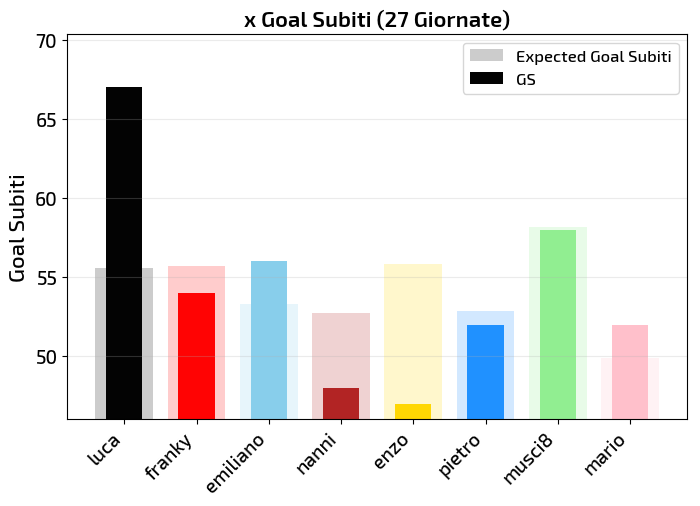

In [287]:
fig = plt.figure(figsize=(8,5))

colors = get_team_colors()

plt.bar(np.arange(0,8), Total['x_GS'], color=colors, alpha=0.2, label='Expected Goal Subiti')
plt.bar(np.arange(0,8), Total['GS'], color=colors, alpha=0.99, width=0.5, label='GS')
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.grid(which='both', axis='y', alpha=0.25)

plt.ylim(ymin = np.min(Total['GS']-1))
plt.ylabel('Goal Subiti')
title = 'x Goal Subiti (' + str(giornate) + ' Giornate)'
plt.title(title)

plt.legend()

plt.show()

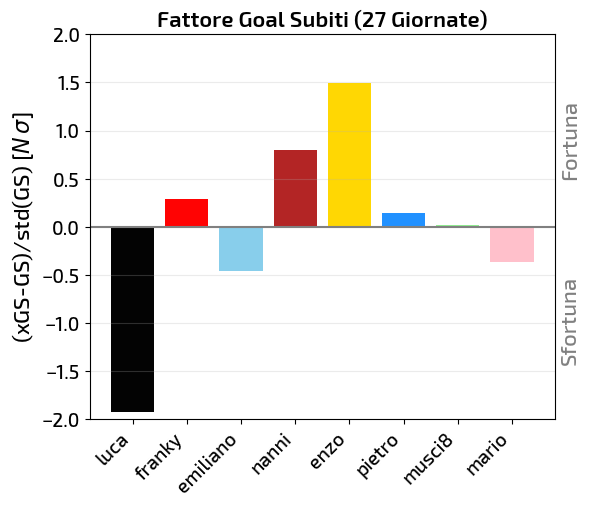

In [288]:
fig = plt.figure(figsize=(6,5))
plt.grid(which='both', axis='y', ls='-', alpha=0.25)

colors = get_team_colors()

std = np.std(Total['GS'])
plt.bar(np.arange(0,8), -1*(Total['GS']-Total['x_GS'])/std, color=colors, alpha=0.99, width=0.8, label='Fattore GS')
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')
plt.ylim(-2,2)

plt.ylabel('(xGS-GS)/std(GS) [$N\,\sigma$]')
title = 'Fattore Goal Subiti (' + str(giornate) + ' Giornate)'
plt.title(title)

plt.text(x=8.25, y=+0.5, s='Fortuna', verticalalignment='bottom', horizontalalignment='right', color='grey', rotation='90')
plt.text(x=8.25, y=-0.5, s='Sfortuna', verticalalignment='top', horizontalalignment='right', color='grey', rotation='90')


#plt.legend()

plt.show()

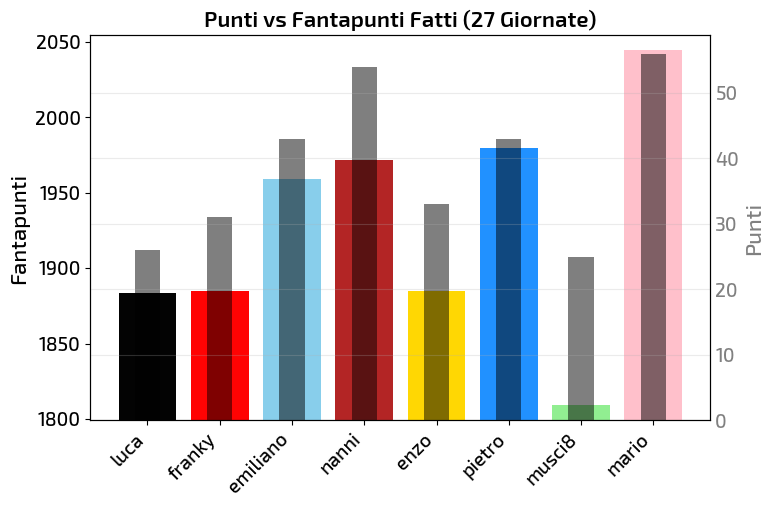

In [289]:
### Punti fatti vs classifica ###############
fig = plt.figure(figsize=(8,5))

colors = get_team_colors()
x = Total['punti_fatti']
y = Total['pti']

plt.bar(np.arange(0,8), x, color=colors, alpha=0.99, label='Expected Goal Subiti')
plt.ylabel('Fantapunti')
plt.ylim(np.min(x)-10, np.max(x)+10)
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')

# secondary y axis
ax2 = plt.twinx()
ax2.set_ylabel('Fantapunti')
ax2.tick_params(axis='y', colors='grey', length=0)
ax2.yaxis.label.set_color('grey')
ax2.plot([],[])

plt.bar(np.arange(0,8), y, color='black', alpha=0.5, width=0.35, label='GS')


#plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.grid(which='both', axis='y', alpha=0.25)

#plt.ylim(ymin = np.min(Total['GS']-1))
plt.ylabel('Punti')
title = 'Punti vs Fantapunti Fatti (' + str(giornate) + ' Giornate)'
plt.title(title)

#plt.legend()

plt.show()

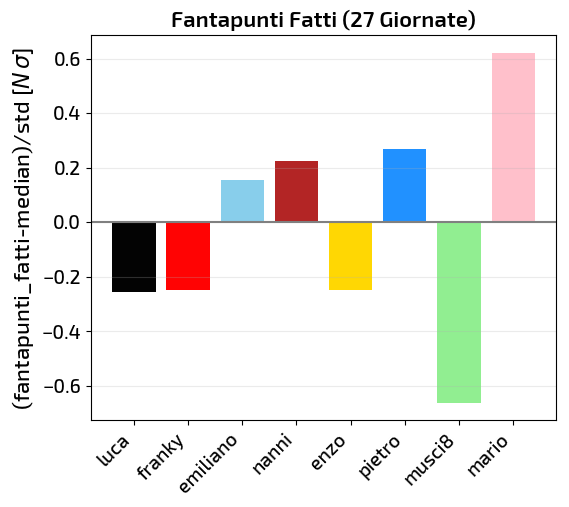

In [290]:
fig = plt.figure(figsize=(6,5))
plt.grid(which='both', axis='y', ls='-', alpha = 0.25)

colors = get_team_colors()
    
std = pf_std*giornate
med = pf_med*giornate

plt.bar(np.arange(0,8), (Total['punti_fatti']-med)/std, color=colors, alpha=0.99, width=0.8, label='')
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')
#plt.ylim(-2,2)

plt.ylabel('(fantapunti_fatti-median)/std [$N\,\sigma$]')
title = 'Fantapunti Fatti (' + str(giornate) + ' Giornate)'
plt.title(title)

plt.show()

# [>] Close games

In [291]:
close_games(verbose=True)


### luca ###
G 4 | punti fatti: 68.5  ( subiti: 70.5 ) | S ( 1 - 2 )
G 7 | punti fatti: 73.0  ( subiti: 74.5 ) | S ( 2 - 3 )
G 16 | punti fatti: 68.5  ( subiti: 68.0 ) | P ( 1 - 1 )
G 23 | punti fatti: 77.0  ( subiti: 76.5 ) | P ( 3 - 3 )
---> 2 punti in 4 giornate 
     (media: 0.50)

### franky ###
G 4 | punti fatti: 73.0  ( subiti: 73.0 ) | P ( 2 - 2 )
G 9 | punti fatti: 75.0  ( subiti: 75.5 ) | P ( 3 - 3 )
G 11 | punti fatti: 61.5  ( subiti: 59.5 ) | P ( 0 - 0 )
G 18 | punti fatti: 65.0  ( subiti: 66.0 ) | S ( 0 - 1 )
G 20 | punti fatti: 72.5  ( subiti: 74.5 ) | S ( 2 - 3 )
---> 3 punti in 5 giornate 
     (media: 0.60)

### emiliano ###
G 16 | punti fatti: 68.0  ( subiti: 68.5 ) | P ( 1 - 1 )
G 21 | punti fatti: 77.0  ( subiti: 75.5 ) | P ( 3 - 3 )
G 23 | punti fatti: 76.5  ( subiti: 77.0 ) | P ( 3 - 3 )
G 24 | punti fatti: 79.5  ( subiti: 77.5 ) | V ( 4 - 3 )
G 26 | punti fatti: 67.0  ( subiti: 67.0 ) | P ( 1 - 1 )
---> 7 punti in 5 giornate 
     (media: 1.40)

### nanni ###
G 

[-2, -2, 2, 5, -2, 0, 3, 4]

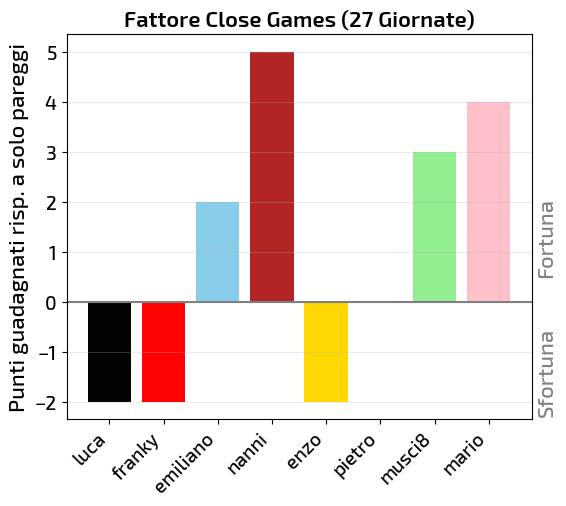

In [292]:
fig = plt.figure(figsize=(6,5))
plt.grid(which='major', axis='y', ls='-', alpha=0.25)

colors = get_team_colors()

plt.bar(np.arange(0,8), Total['f_close_games'], color=colors, alpha=0.99, width=0.8, label='')
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')

ylim = np.max(np.abs(Total['f_close_games']))*1.1
#plt.ylim(-2.1,2.1)

plt.ylabel('Punti guadagnati risp. a solo pareggi')
title = 'Fattore Close Games (' + str(giornate) + ' Giornate)'
plt.title(title)

plt.text(x=8.25, y=+0.5, s='Fortuna', verticalalignment='bottom', horizontalalignment='right', color='grey', rotation='90')
plt.text(x=8.25, y=-0.5, s='Sfortuna', verticalalignment='top', horizontalalignment='right', color='grey', rotation='90')

plt.show()

In [293]:
### Stolen Games #########################
exact_fp(verbose=True)


### luca ###
G 2 | punti fatti: 74.0  ( subiti: 66.5 ) | V ( 3 - 1 )
G 25 | punti fatti: 66.0  ( subiti: 75.0 ) | S ( 1 - 3 )
---> 0 punti rubati in 2 giornate

### franky ###
G 25 | punti fatti: 70.0  ( subiti: 62.0 ) | V ( 2 - 0 )
---> 0 punti rubati in 1 giornate

### emiliano ###
G 1 | punti fatti: 74.0  ( subiti: 87.0 ) | S ( 3 - 6 )
G 17 | punti fatti: 70.0  ( subiti: 75.5 ) | S ( 2 - 3 )
---> 0 punti rubati in 2 giornate

### nanni ###
G 6 | punti fatti: 74.0  ( subiti: 73.0 ) | V ( 3 - 2 )
G 11 | punti fatti: 74.0  ( subiti: 71.5 ) | V ( 3 - 2 )
G 15 | punti fatti: 66.0  ( subiti: 65.0 ) | V ( 1 - 0 )
G 22 | punti fatti: 70.0  ( subiti: 77.5 ) | S ( 2 - 3 )
G 26 | punti fatti: 74.0  ( subiti: 77.5 ) | P ( 3 - 3 )
---> 7 punti rubati in 5 giornate

### enzo ###
G 18 | punti fatti: 66.0  ( subiti: 78.5 ) | S ( 1 - 4 )
G 27 | punti fatti: 66.0  ( subiti: 68.0 ) | P ( 1 - 1 )
---> 1 punti rubati in 2 giornate

### pietro ###
G 12 | punti fatti: 66.0  ( subiti: 73.5 ) | S ( 1 - 2 )

[0, 0, 0, 7, 1, 2, 2, 0]

In [294]:
### Unlucky opponent ###########################
opponent_almost_scored(verbose=True)


### luca ###
---> 0 punti rubati in 0 giornate

### franky ###
G 14 | punti fatti: 73.5  ( subiti: 69.5 ) | V ( 2 - 1 )
G 16 | punti fatti: 68.5  ( subiti: 73.5 ) | S ( 1 - 2 )
G 23 | punti fatti: 71.5  ( subiti: 65.5 ) | V ( 2 - 0 )
---> 2 punti rubati in 3 giornate

### emiliano ###
G 13 | punti fatti: 71.0  ( subiti: 65.5 ) | V ( 2 - 0 )
G 24 | punti fatti: 79.5  ( subiti: 77.5 ) | V ( 4 - 3 )
G 27 | punti fatti: 60.5  ( subiti: 69.5 ) | S ( 0 - 1 )
---> 2 punti rubati in 3 giornate

### nanni ###
G 22 | punti fatti: 70.0  ( subiti: 77.5 ) | S ( 2 - 3 )
G 26 | punti fatti: 74.0  ( subiti: 77.5 ) | P ( 3 - 3 )
---> 1 punti rubati in 2 giornate

### enzo ###
G 1 | punti fatti: 62.5  ( subiti: 81.5 ) | S ( 0 - 4 )
G 14 | punti fatti: 69.5  ( subiti: 73.5 ) | S ( 1 - 2 )
G 16 | punti fatti: 72.0  ( subiti: 65.5 ) | V ( 2 - 0 )
G 26 | punti fatti: 75.5  ( subiti: 65.5 ) | V ( 3 - 0 )
---> 0 punti rubati in 4 giornate

### pietro ###
G 2 | punti fatti: 70.5  ( subiti: 77.5 ) | S ( 2 - 3 

[0, 2, 2, 1, 0, 0, 0, 0]

# <<<<< Indice Fortuna >>>>>

In [295]:
def get_bigradient_colors():
    colors = []
    edgecolors = []
    for key in Teams.keys():
        x = Total[Total['Team']==key]['IndiceFortuna'].sum()
        if Total[Total['Team']==key]['IndiceFortuna'].sum() >= 0:
            x = (max_f - Total[Total['Team']==key]['IndiceFortuna'].sum())/max_f
            s = (x,1,x)
            colors.append(s)
            edgecolors.append('g')
            #edgecolors.append('limegreen')
        else: 
            x = -(Total[Total['Team']==key]['IndiceFortuna'].sum() - min_f)/min_f
            s=(1,x,x)
            colors.append(s)
            #edgecolors.append('orangered')
            edgecolors.append('r')
    return colors, edgecolors

# Take negative and positive data apart and cumulate
def get_cumulated_array(data, **kwargs):
    cum = data.clip(**kwargs)
    cum = np.cumsum(cum, axis=0)
    d = np.zeros(np.shape(data))
    d[1:] = cum[:-1]
    return d 


tot_giornate = 28

keys = ('f_pos', 'f_distacco', 'f_GS', 'f_close_games', 'f_stolen_games', 'f_unlucky_opponent')
scaling = (0.5, 1, 1, 0.5, 0.25*tot_giornate/giornate, 0.25*tot_giornate/giornate)
#scaling = (10.5, 1, 1, 0.5, 0.25, 0.25)

cols = ['dodgerblue', 'purple', 'r', 'gold', 'c', 'lime']
#keys = ('f_distacco', 'f_GS', 'f_closegames')
#scaling = (1, 1, 0.5)
#cols = ['dodgerblue', 'purple', 'gold']

def calc_fortuna(df):
    factors = []
    df['IndiceFortuna'] = [0,0,0,0,0,0,0,0]
    ### build fortuna
    for col,scale in zip(keys,scaling):
        factors.append(df[col]*scale)
        df['IndiceFortuna'] = df['IndiceFortuna'] + df[col]*scale
    #print(len(factors))
    return df, factors


    


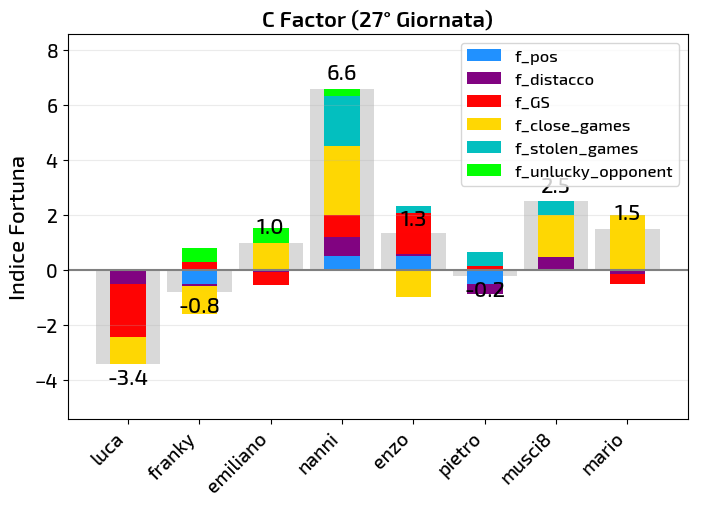

In [296]:
#--- Fortuna Total
Total, __factors__ = calc_fortuna(Total)
matchday = giornate
data_per_round = make_Total_df(giornate = matchday)
__df__, __factors__ = calc_fortuna(data_per_round)



# re-shape data for positive-negative bar plot
__data__ = np.array(__factors__)
#print(__data__)
data_shape = np.shape(__data__)
#print(data_shape)
cumulated_data = get_cumulated_array(__data__, min=0)
cumulated_data_neg = get_cumulated_array(__data__, max=0)
# Re-merge negative and positive data.
row_mask = (__data__<0)
cumulated_data[row_mask] = cumulated_data_neg[row_mask]
data_stack = cumulated_data
#print(np.shape(data_stack))



fig = plt.figure(figsize=(8,5))
plt.grid(which='major', axis='y', ls='-', alpha=0.25)
xlabels = __df__['Team']
plt.xticks(__df__.index, xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')

max_f = max(__df__['IndiceFortuna'])
min_f = np.min(__df__['IndiceFortuna'])
colors, edgecolors = get_bigradient_colors()
plt.bar(np.arange(0,8), __df__['IndiceFortuna'], color='black', edgecolor=edgecolors, lw=0, alpha=0.15, width=0.9, label='')

#print(np.arange(0, data_shape[0]))

for i in np.arange(0, data_shape[0]):
    plt.bar(np.arange(data_shape[1]), __data__[i], bottom=data_stack[i], color=cols[i],alpha=0.99, width=0.5, label=keys[i])
    
plt.legend()

for i, f in enumerate(list(np.round(__df__['IndiceFortuna'],decimals=1))):
    if f<0: 
        va = 'top'
        offset = -0.2
    else: 
        va = 'bottom'
        offset = 0.2
    plt.annotate(f, (i, f+offset), horizontalalignment='center', verticalalignment=va)
    
plt.ylim(min_f-2, max_f+2)

plt.ylabel('Indice Fortuna')
title = 'C Factor (' + str(matchday) + '° Giornata)'
plt.title(title)
plt.show()



#Total.head(10)

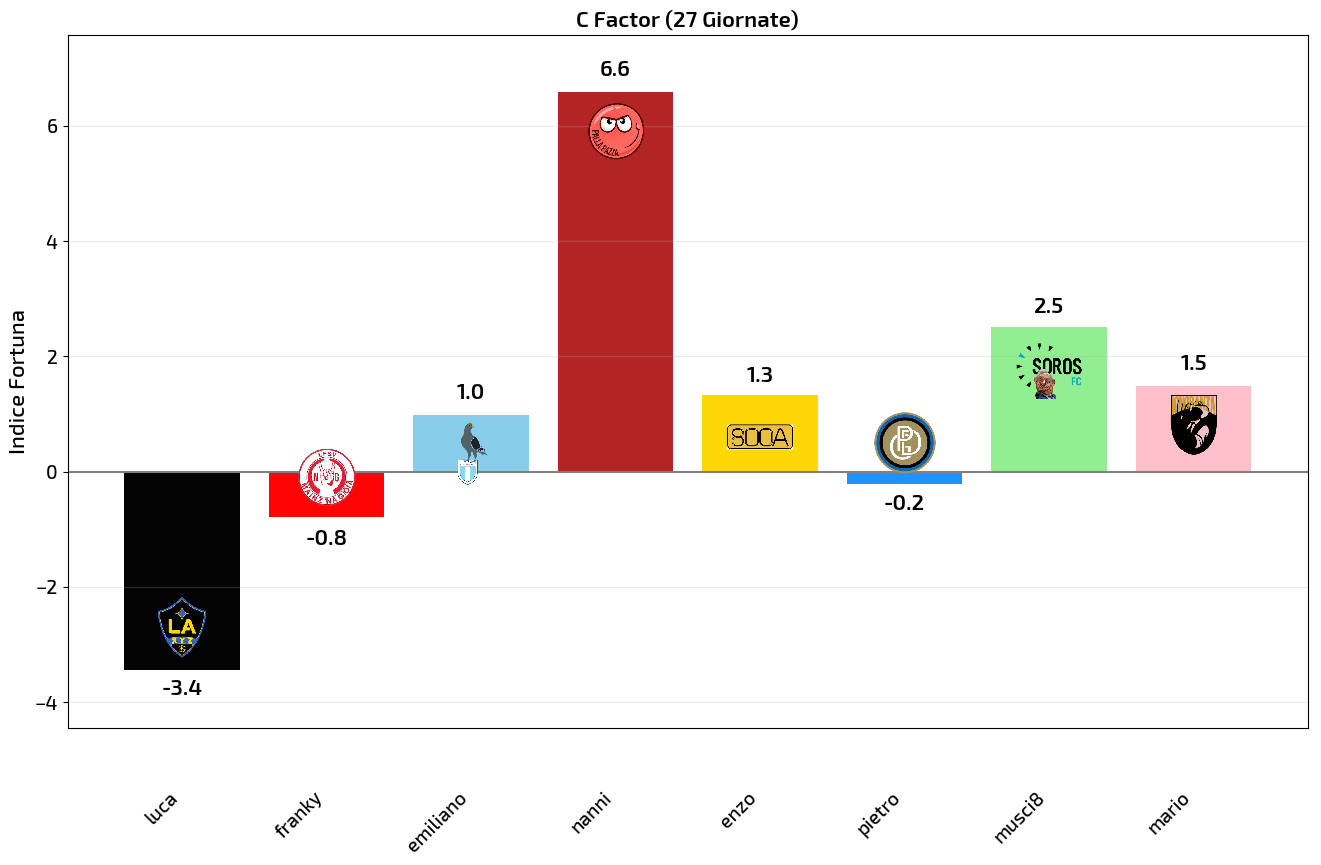

In [297]:
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

def offset_image(x,y, name, ax):
    img = plt.imread(Logos[name])
    im = OffsetImage(img, zoom=0.2)
    im.image.axes = ax

    ab = AnnotationBbox(im, (x, y),  xybox=(0., 0.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)


fig = plt.figure(figsize=(16,9))
ax=fig.add_subplot(111)

plt.grid(which='major', axis='y', ls='-', alpha=0.25)
#xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')

max_f = max(Total['IndiceFortuna'])
min_f = np.min(Total['IndiceFortuna'])
colors = get_team_colors()
ax.bar(np.arange(0,8), Total['IndiceFortuna'], color=colors, lw=0, alpha=0.99, width=0.8, label='')

for i, f in enumerate(list(np.round(Total['IndiceFortuna'],decimals=1))):
    if f<0: 
        va = 'top'
        offset = -0.2
    else: 
        va = 'bottom'
        offset = 0.2
    plt.annotate(f, (i, f+offset), horizontalalignment='center', verticalalignment=va, weight='bold')
    offset_image(i,f-3.5*offset, Total['Team'].iat[i], ax)
    
plt.ylim(min_f-1, max_f+1)
plt.ylabel('Indice Fortuna')
title = 'C Factor (' + str(giornate) + ' Giornate)'
plt.title(title)



    
ax.tick_params(axis='x', which='major', pad=40, bottom=False)
#for i, team in enumerate(Teams.keys()):
#    offset_image(i, team, ax)


plt.show()

In [298]:
Total['Team']

0        luca
1      franky
2    emiliano
3       nanni
4        enzo
5      pietro
6      musci8
7       mario
Name: Team, dtype: object

In [299]:
#--- build partial Total entries
print('... Filling Total df per round ...')
Tot_per_round = []
for gg in Results['luca'].index:
    data_per_round = make_Total_df(giornate = gg)
    #print(data_per_round.dtypes)
    __df__, __factors__ = calc_fortuna(data_per_round)
    Tot_per_round.append(__df__)

... Filling Total df per round ...


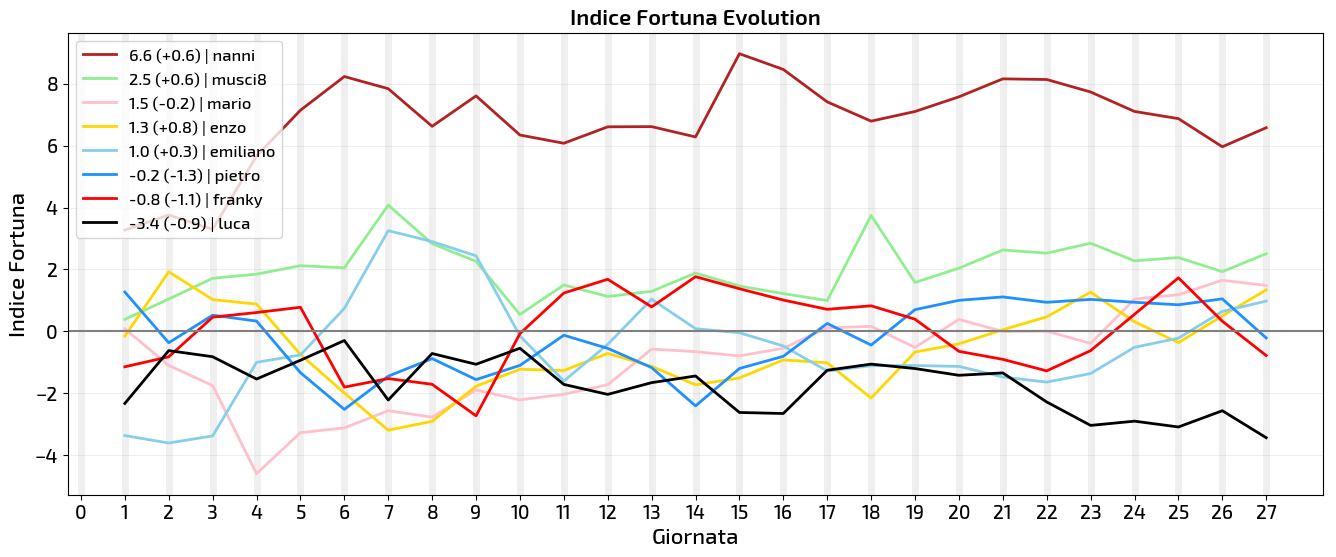

In [300]:
def fortuna_evo(title='Indice Fortuna Evolution', ylabel='Indice Fortuna'):

    giornate = Results['luca'].index
    gg = max(giornate)
    fig = plt.figure(figsize=(gg*0.6,6))

    data = []
    for team in Teams.keys():
        dd = pd.DataFrame()
        score = 0
        scores = []
        for df in Tot_per_round:
            _ = df[df['Team'] == team]
            score = _['IndiceFortuna'].sum()
            #print(team, score)
            scores.append(score)
        dd['score'] = scores
        dd['Team'] = team
        data.append(dd)

    data = sorted(data,key=lambda x:x.at[gg-1,'score'].min(axis=0), reverse=True)

    for df in data:
        team = df['Team'].unique()[0]
        color = Teams[team][1]
        score = df.at[gg-1, 'score']
        score_prev = df.at[gg-2, 'score']
        diff = score - score_prev
        if diff > 0: sign='+'
        else: sign=''
        label = '%.1f (%s%.1f) | %s' % (score, sign, diff, team)
        p = plt.plot(giornate, df['score'], color=color, ls='-', lw=2, label=label)

    plt.xticks(np.arange(0,gg+1))
    plt.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
    plt.grid(axis='y', alpha=0.2)
    plt.axhline(0, color='grey')
    plt.xlabel('Giornata')
    plt.ylabel(ylabel)
    plt.title(title)

    plt.legend(loc="upper left")
    plt.show()
    
fortuna_evo()

In [301]:
Tot_per_round[1].keys()

Index(['punti_fatti', 'punti_subiti', 'goal_subiti_por', 'cartellini',
       'bonus_panchina', 'mod_difesa', 'mod_fairplay', 'GF', 'GS', 'esito',
       'pti', 'Team', 'pos', 'rank', 'distacco', 'f_pos', 'f_distacco',
       'x_punti_subiti', 'x_GS', 'f_GS', 'f_close_games', 'f_stolen_games',
       'f_unlucky_opponent', 'IndiceFortuna'],
      dtype='object')

# [>] Premi Ignobel

In [302]:
 def premio_plot(par = 'goal_subiti_por', threshold=2, title='Premio Porta Violata "Mario Bruno"', ylabel='Goal subiti dal portiere'):
    giornate = Results['luca'].index
    gg = max(giornate)
    fig = plt.figure(figsize=(gg*0.6,6))

    data = []
    for team, df in Results.items():
        df['cumsum'] = np.cumsum(df[par])
        score = max(df['cumsum'])
        df['score'] = score
        
        df_prev = df.drop(df.tail(1).index)         
        df_prev['cumsum_prev'] = np.cumsum(df_prev[par])
        score_prev = max(df_prev['cumsum'])
        df['score_prev'] = score_prev
        
        data.append(df)
    data = sorted(data,key=lambda x:x['score'].unique().min(axis=0), reverse=True)

    for df in data:
        team = df['Team'].unique()[0]
        color = Teams[team][1]
        df['cumsum'] = np.cumsum(df[par])
        score = max(df['cumsum'])
        score_prev = max(df['score_prev'])
        diff = score - score_prev
        p = plt.plot(giornate, df['cumsum'], color=color, ls='-', lw=2, label=str(score)+' (+'+str(diff)+') | '+str(team))
        #col = p[0].get_color()

        gior = df[df[par]>threshold].index
        dd = df[df.index.isin(gior)]
        marks = dd['cumsum']

        #cs = np.cumsum(dd[par])
        plt.scatter(gior, marks, edgecolor=color, facecolor=color, s=300+20*dd[par], label='')
        for x,y,text in zip(gior,marks,dd[par]):
            plt.text(x, y,text, horizontalalignment='center', verticalalignment='center', color='white')

    plt.xticks(np.arange(0,gg+1))
    plt.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
    plt.xlabel('Giornata')
    plt.ylabel(ylabel)
    plt.title(title, fontsize=20)

    plt.legend()
    plt.show()

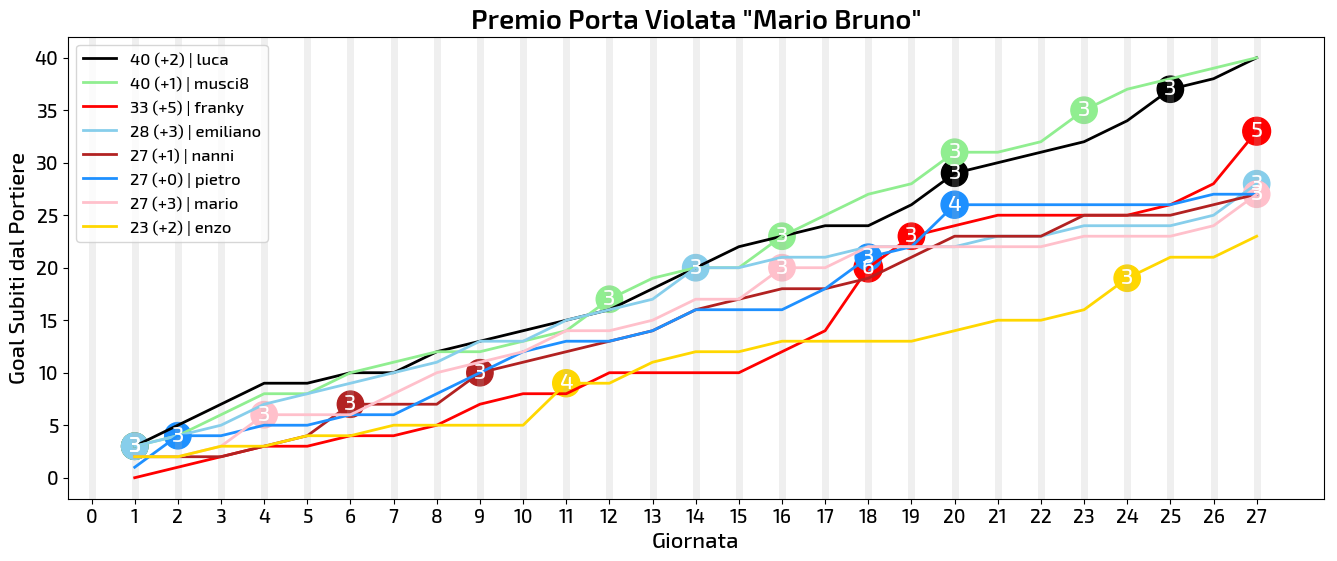

In [303]:
premio_plot(par='goal_subiti_por', title='Premio Porta Violata "Mario Bruno"', ylabel='Goal Subiti dal Portiere')

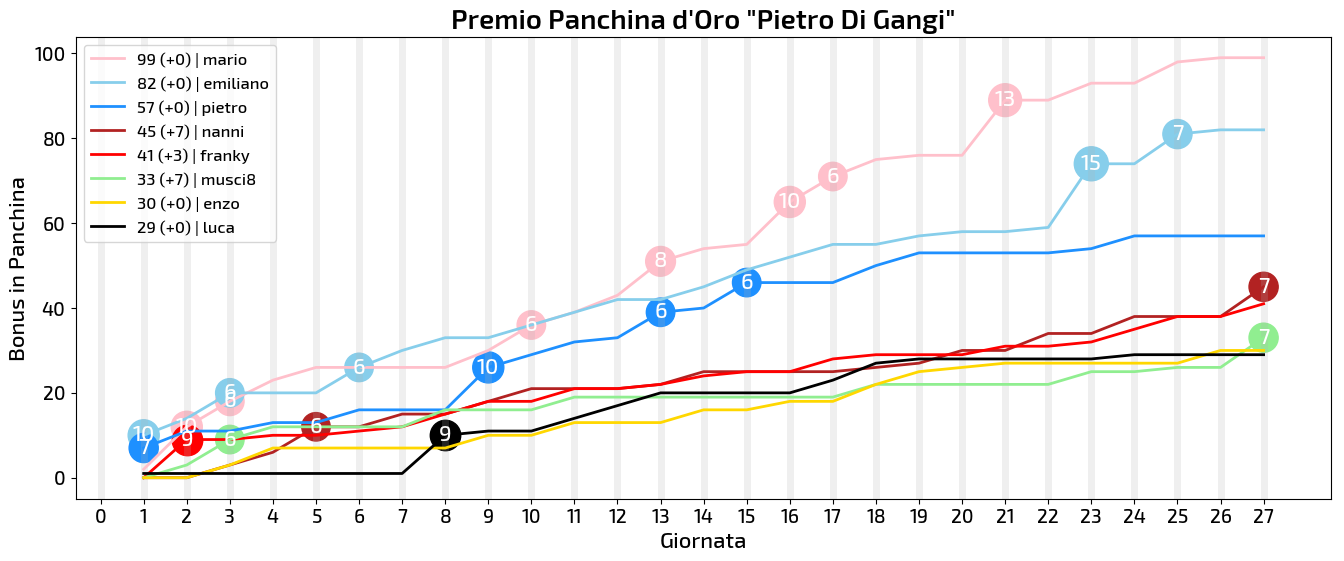

In [304]:
premio_plot(par='bonus_panchina', threshold=5, title='Premio Panchina d\'Oro "Pietro Di Gangi"', ylabel='Bonus in Panchina')

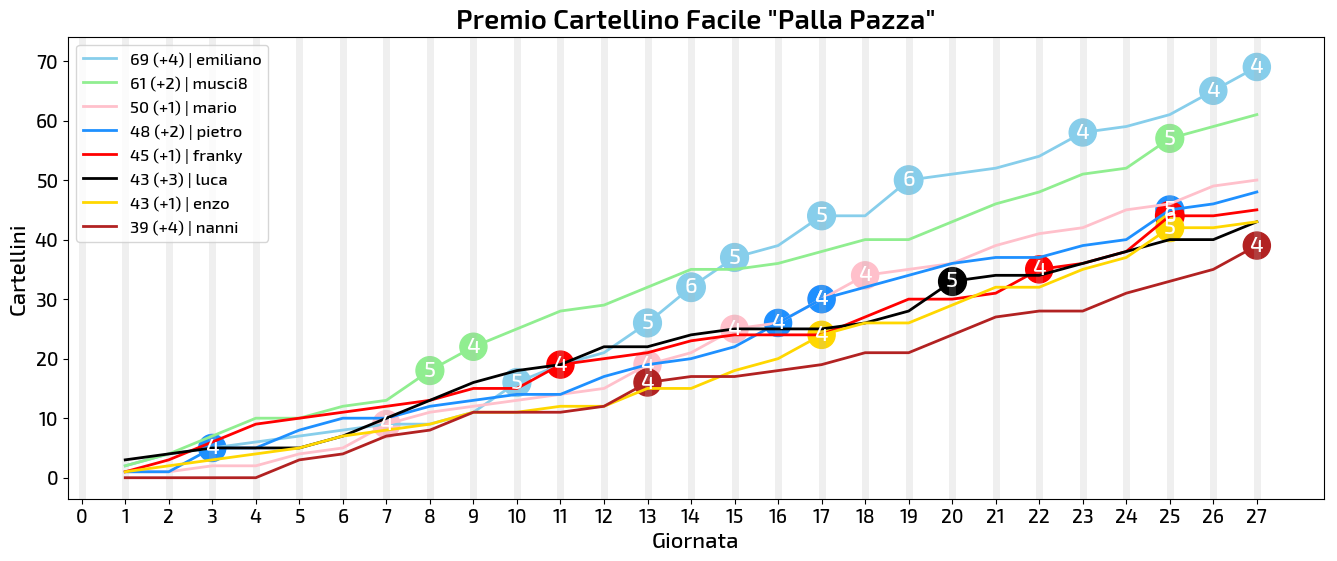

In [305]:
premio_plot(par='cartellini', threshold=3, title='Premio Cartellino Facile "Palla Pazza"', ylabel='Cartellini') 

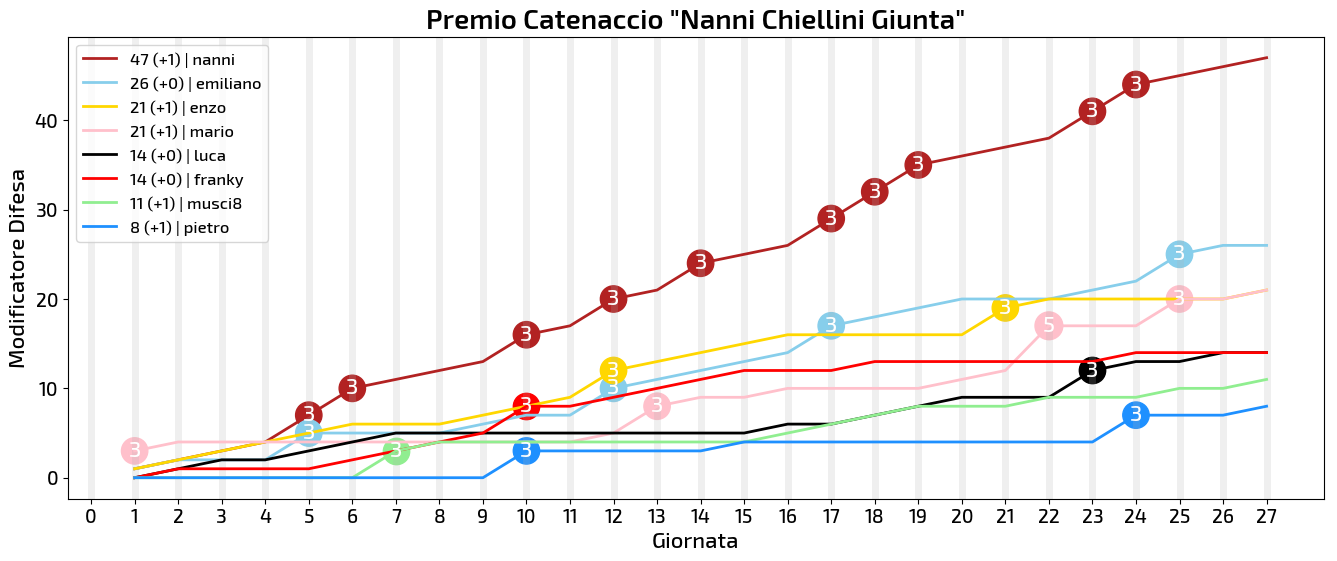

In [306]:
premio_plot(par='mod_difesa', threshold=2, title='Premio Catenaccio "Nanni Chiellini Giunta"', ylabel='Modificatore Difesa') 

# [>] Box plots

In [307]:
###--- Melt dataframe with variables of interest ######################
def melt_df(variables = ['punti_subiti', 'punti_fatti']):
    data = []
    for team, df in Results.items():
        dd = pd.DataFrame()
        dd['Team'] = df['Team']
        for key in variables:
            dd[key] = df[key]
        data.append(dd)
    cdf = pd.concat(data)    
    mdf = pd.melt(cdf, id_vars=['Team'], var_name=['Variable'])
    return mdf

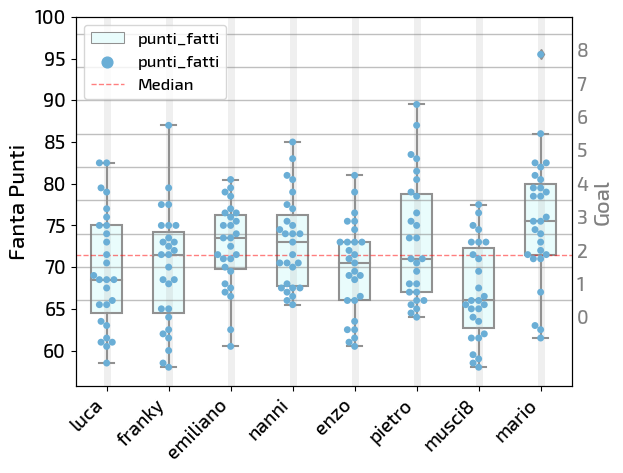

In [308]:
### Box plot ##############################
data = melt_df(['punti_fatti'])

# box plot
ax = sns.boxplot(x="Team", y="value", hue="Variable", data=data, color='cyan', whis=1.5, width=0.5)    
# draw single datapoints
ax = sns.swarmplot(x="Team", y="value", hue="Variable", data=data, palette="Blues")    

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#ax.set_ylim(-2,16)
ax.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
ax.hlines(goal_marks, -1000,1000, 'grey','-', linewidth=1, alpha=0.5)
ax.hlines(ps_med,-100,100, colors='red', linewidth=1, linestyles='--', alpha=0.5, label='Median')


ax.set_ylabel('Fanta Punti')
ax.set_xlabel('')
ax.legend()

# secondary y axis
ax2 = ax.twinx()
goal = lambda fp: (fp-66)/4 + 0.5 
ymin, ymax = ax.get_ylim()
ax2.set_ylim((goal(ymin),goal(ymax)))
ax2.set_yticks([0,1,2,3,4,5,6,7,8])
ax2.set_ylabel('Goal')
ax2.tick_params(axis='y', colors='grey', length=0)
ax2.yaxis.label.set_color('grey')
ax2.plot([],[])

plt.show()

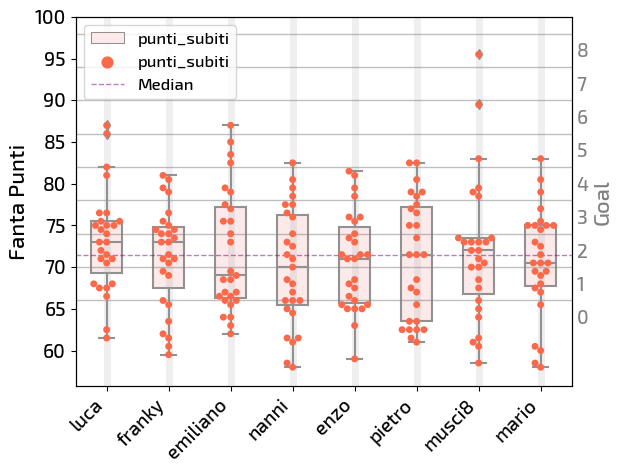

In [309]:
### Box plot ##############################
data = melt_df(['punti_subiti'])

# box plot
ax = sns.boxplot(x="Team", y="value", hue="Variable", data=data, color='r', whis=1.5, width=0.5)    
# draw single datapoints
ax = sns.swarmplot(x="Team", y="value", hue="Variable", data=data, palette="Reds")    

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#ax.set_ylim(-2,16)
ax.grid(axis='x', linestyle='-', linewidth=5, alpha=0.2)
ax.hlines(goal_marks, -1000,1000, 'grey','-', linewidth=1, alpha=0.5)
ax.hlines(ps_med,-100,100, colors='purple', linewidth=1, linestyles='--', alpha=0.5, label='Median')


ax.set_ylabel('Fanta Punti')
ax.set_xlabel('')
ax.legend()

# secondary y axis
ax2 = ax.twinx()
goal = lambda fp: (fp-66)/4 + 0.5 
ymin, ymax = ax.get_ylim()
ax2.set_ylim((goal(ymin),goal(ymax)))
ax2.set_yticks([0,1,2,3,4,5,6,7,8])
ax2.set_ylabel('Goal')
ax2.tick_params(axis='y', colors='grey', length=0)
ax2.yaxis.label.set_color('grey')
ax2.plot([],[])

plt.show()

# [>] Scores sotto la media

In [310]:
def print_low_scoring_results():
    media, giornate = [], []
    for team, df in Results.items():
        print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if ((df['punti_fatti'][gg]<pf_med) & (df['punti_fatti'][gg]>=62)):
                res = esito(df.GF[gg], df.GS[gg])
                print('G', gg, ':', df.punti_fatti[gg], '|', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        print('--->', pti, 'punti in', g, 'giornate ( media:', pti/g,')')
        media.append(pti/g)
        giornate.append(g)
    return media, giornate
        
        

        
        
def print_very_low_scoring_results():
    for team, df in Results.items():
        print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if df['punti_fatti'][gg]<62:
                res = esito(df.GF[gg], df.GS[gg])
                print('G', gg, ':', df.punti_fatti[gg], '|', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        try:
            print('--->', pti, 'punti in', g, 'giornate ( media:', pti/g,')')
        except:
            print('No games < 62 fantapunti found')
            
            
            
def print_high_scoring_results():
    media, giornate = [], []
    for team, df in Results.items():
        print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if (df['punti_fatti'][gg]>=74):
                res = esito(df.GF[gg], df.GS[gg])
                print('G', gg, ':', df.punti_fatti[gg], '|', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        print('--->', pti, 'punti in', g, 'giornate ( media:', pti/g,')')
        media.append(pti/g)
        giornate.append(g)
    return media, giornate


def print_great_opponent(punti_subiti=82):
    media, giornate = [], []
    for team, df in Results.items():
        print('\n###', team, '###')
        pti=0
        g = 0.000000001
        ps = 0
        for gg in df.index:     
            if (df['punti_subiti'][gg]>=punti_subiti):
                res = esito(df.GF[gg], df.GS[gg])
                print('G', gg, ':', df.punti_fatti[gg], '|', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                ps = ps + df['punti_subiti'][gg]
                g = g+1
        print('--->', pti, 'punti in', g, 'giornate ( media:', pti/g,')')
        media.append(ps/g)
        giornate.append(g)
    return media, giornate


### luca ###
G 1 : 70.5 | S ( 2 - 5 )
G 4 : 68.5 | S ( 1 - 2 )
G 10 : 63.5 | S ( 0 - 2 )
G 12 : 68.5 | S ( 1 - 3 )
G 15 : 65.5 | S ( 0 - 3 )
G 16 : 68.5 | P ( 1 - 1 )
G 17 : 69.0 | V ( 1 - 0 )
G 19 : 63.0 | S ( 0 - 4 )
G 22 : 67.5 | S ( 1 - 6 )
G 25 : 66.0 | S ( 1 - 3 )
G 26 : 65.5 | S ( 0 - 3 )
---> 4 punti in 11 giornate ( media: 0.36363636363636365 )

### franky ###
G 8 : 62.0 | S ( 0 - 2 )
G 12 : 68.0 | S ( 1 - 2 )
G 15 : 64.0 | S ( 0 - 3 )
G 16 : 68.5 | S ( 1 - 2 )
G 17 : 62.5 | S ( 0 - 1 )
G 18 : 65.0 | S ( 0 - 1 )
G 21 : 65.0 | S ( 0 - 3 )
G 22 : 68.5 | S ( 1 - 3 )
G 25 : 70.0 | V ( 2 - 0 )
---> 3 punti in 9 giornate ( media: 0.3333333333333333 )

### emiliano ###
G 2 : 66.5 | S ( 1 - 3 )
G 8 : 71.0 | V ( 2 - 0 )
G 13 : 71.0 | V ( 2 - 0 )
G 14 : 69.5 | S ( 1 - 5 )
G 16 : 68.0 | P ( 1 - 1 )
G 17 : 70.0 | S ( 2 - 3 )
G 19 : 62.5 | S ( 0 - 5 )
G 20 : 67.5 | S ( 1 - 2 )
G 26 : 67.0 | P ( 1 - 1 )
---> 8 punti in 9 giornate ( media: 0.8888888888888888 )

### nanni ###
G 1 : 70.5 | V 

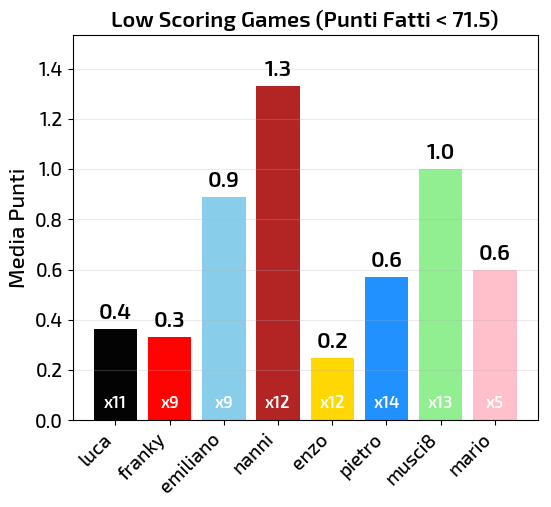

In [311]:
media, partite = print_low_scoring_results()

fig = plt.figure(figsize=(6,5))
plt.grid(which='major', axis='y', ls='-', alpha=0.25)
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
#plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')

max_f = max(Total['IndiceFortuna'])
min_f = np.min(Total['IndiceFortuna'])
colors = get_team_colors()
plt.bar(np.arange(0,8), media, color=colors, lw=0, alpha=0.99, width=0.8, label='')

for i, m in enumerate(list(media)):
    va = 'top'
    offset = 0.1
    plt.annotate(np.round(m, decimals=1), (i, m+1*offset), horizontalalignment='center', verticalalignment=va, weight='bold')
    plt.annotate('x' + str(partite[i]), (i, 0+1*offset), horizontalalignment='center', verticalalignment=va, fontsize=12, color='white', weight='bold')

plt.ylim(0, max(media)+2*offset)
plt.ylabel('Media Punti')
title = 'Low Scoring Games (Punti Fatti < %.1f)' % pf_med
plt.title(title)
plt.show()

In [312]:
print_very_low_scoring_results()


### luca ###
G 3 : 60.5 | S ( 0 - 2 )
G 14 : 58.5 | S ( 0 - 1 )
G 20 : 61.0 | S ( 0 - 3 )
G 21 : 61.0 | S ( 0 - 2 )
G 24 : 61.5 | S ( 0 - 2 )
---> 0 punti in 5 giornate ( media: 0.0 )

### franky ###
G 5 : 58.0 | S ( 0 - 2 )
G 11 : 61.5 | P ( 0 - 0 )
G 13 : 60.0 | S ( 0 - 4 )
G 19 : 58.5 | S ( 0 - 4 )
---> 1 punti in 4 giornate ( media: 0.25 )

### emiliano ###
G 27 : 60.5 | S ( 0 - 1 )
---> 0 punti in 1 giornate ( media: 0.0 )

### nanni ###
No games < 62 fantapunti found

### enzo ###
G 13 : 61.0 | S ( 0 - 4 )
G 17 : 60.5 | S ( 0 - 2 )
G 20 : 61.5 | S ( 0 - 1 )
---> 0 punti in 3 giornate ( media: 0.0 )

### pietro ###
No games < 62 fantapunti found

### musci8 ###
G 2 : 59.0 | S ( 0 - 2 )
G 3 : 61.5 | P ( 0 - 0 )
G 5 : 58.0 | S ( 0 - 2 )
G 8 : 61.5 | S ( 0 - 5 )
G 11 : 59.5 | P ( 0 - 0 )
G 12 : 58.5 | S ( 0 - 4 )
---> 2 punti in 6 giornate ( media: 0.3333333333333333 )

### mario ###
G 8 : 61.5 | S ( 0 - 3 )
---> 0 punti in 1 giornate ( media: 0.0 )


In [313]:
def print_1GF_results():
    for team, df in Results.items():
        print('\n###', team, '###')
        pti=0
        g = 0
        for gg in df.index:     
            if df['GF'][gg] == 1:
                res = esito(df.GF[gg], df.GS[gg])
                print('G', gg, ':', df.punti_fatti[gg], '|', res, '(', df.GF[gg], '-', df.GS[gg], ')')
                pti = pti+punti(res)
                g = g+1
        try:
            print('--->', pti, 'punti in', g, 'giornate ( media:', pti/g,')')
        except: 
            print('No games found with GF<=1')

In [314]:
print_1GF_results()


### luca ###
G 4 : 68.5 | S ( 1 - 2 )
G 12 : 68.5 | S ( 1 - 3 )
G 16 : 68.5 | P ( 1 - 1 )
G 17 : 69.0 | V ( 1 - 0 )
G 22 : 67.5 | S ( 1 - 6 )
G 25 : 66.0 | S ( 1 - 3 )
---> 4 punti in 6 giornate ( media: 0.6666666666666666 )

### franky ###
G 12 : 68.0 | S ( 1 - 2 )
G 16 : 68.5 | S ( 1 - 2 )
G 22 : 68.5 | S ( 1 - 3 )
---> 0 punti in 3 giornate ( media: 0.0 )

### emiliano ###
G 2 : 66.5 | S ( 1 - 3 )
G 14 : 69.5 | S ( 1 - 5 )
G 16 : 68.0 | P ( 1 - 1 )
G 20 : 67.5 | S ( 1 - 2 )
G 26 : 67.0 | P ( 1 - 1 )
---> 2 punti in 5 giornate ( media: 0.4 )

### nanni ###
G 3 : 66.5 | S ( 1 - 2 )
G 9 : 67.0 | S ( 1 - 3 )
G 15 : 66.0 | V ( 1 - 0 )
G 18 : 67.5 | S ( 1 - 5 )
G 20 : 67.5 | V ( 1 - 0 )
G 21 : 67.5 | V ( 1 - 0 )
G 27 : 68.0 | P ( 1 - 1 )
---> 10 punti in 7 giornate ( media: 1.4285714285714286 )

### enzo ###
G 4 : 66.5 | S ( 1 - 3 )
G 14 : 69.5 | S ( 1 - 2 )
G 18 : 66.0 | S ( 1 - 4 )
G 23 : 68.5 | P ( 1 - 1 )
G 24 : 69.0 | S ( 1 - 2 )
G 25 : 69.0 | S ( 1 - 3 )
G 27 : 66.0 | P ( 1 - 1 )
-


### luca ###
G 2 : 74.0 | V ( 3 - 1 )
G 5 : 76.0 | V ( 3 - 2 )
G 6 : 75.0 | V ( 3 - 2 )
G 8 : 75.0 | V ( 3 - 0 )
G 9 : 79.5 | V ( 4 - 3 )
G 13 : 79.0 | V ( 4 - 1 )
G 18 : 82.5 | V ( 5 - 1 )
G 23 : 77.0 | P ( 3 - 3 )
G 27 : 82.5 | S ( 5 - 6 )
---> 22 punti in 9 giornate ( media: 2.4444444444444446 )

### franky ###
G 1 : 87.0 | V ( 6 - 3 )
G 2 : 77.5 | V ( 3 - 2 )
G 6 : 75.0 | S ( 3 - 4 )
G 7 : 79.5 | V ( 4 - 2 )
G 9 : 75.0 | P ( 3 - 3 )
G 26 : 77.5 | P ( 3 - 3 )
G 27 : 75.0 | S ( 3 - 4 )
---> 11 punti in 7 giornate ( media: 1.5714285714285714 )

### emiliano ###
G 1 : 74.0 | S ( 3 - 6 )
G 4 : 76.0 | V ( 3 - 1 )
G 5 : 79.0 | V ( 4 - 1 )
G 9 : 75.0 | S ( 3 - 4 )
G 10 : 80.5 | S ( 4 - 5 )
G 15 : 76.5 | V ( 3 - 0 )
G 18 : 78.5 | V ( 4 - 1 )
G 21 : 77.0 | P ( 3 - 3 )
G 22 : 75.0 | V ( 3 - 1 )
G 23 : 76.5 | P ( 3 - 3 )
G 24 : 79.5 | V ( 4 - 3 )
G 25 : 75.5 | V ( 3 - 1 )
---> 23 punti in 12 giornate ( media: 1.9166666666666667 )

### nanni ###
G 2 : 74.5 | V ( 3 - 1 )
G 6 : 74.0 | V ( 3 - 2 

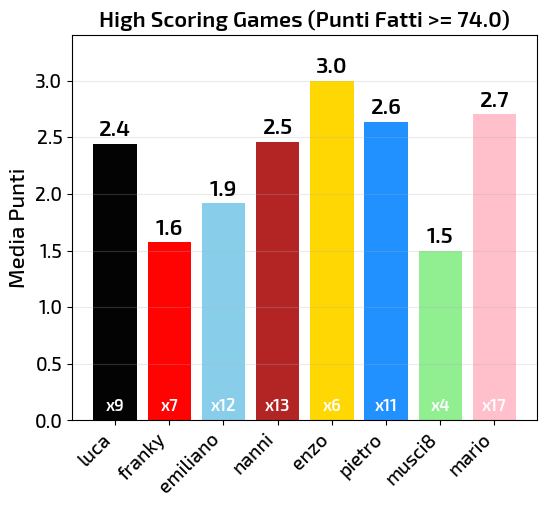

In [315]:
media, partite = print_high_scoring_results()

fig = plt.figure(figsize=(6,5))
plt.grid(which='major', axis='y', ls='-', alpha=0.25)
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')
#plt.axhline(y=0, xmin=-100, xmax=100, color='grey', ls='-')

max_f = max(Total['IndiceFortuna'])
min_f = np.min(Total['IndiceFortuna'])
colors = get_team_colors()
plt.bar(np.arange(0,8), media, color=colors, lw=0, alpha=0.99, width=0.8, label='')

for i, m in enumerate(list(media)):
    va = 'top'
    offset = 0.2
    plt.annotate(np.round(m, decimals=1), (i, m+1*offset), horizontalalignment='center', verticalalignment=va, weight='bold')
    plt.annotate('x' + str(partite[i]), (i, 0+1*offset), horizontalalignment='center', verticalalignment=va, fontsize=12, color='white', weight='bold')

plt.ylim(0, max(media)+2*offset)
plt.ylabel('Media Punti')
title = 'High Scoring Games (Punti Fatti >= %.1f)' % 74
plt.title(title)
plt.show()


### luca ###
G 1 : 70.5 | S ( 2 - 5 )
G 22 : 67.5 | S ( 1 - 6 )
G 27 : 82.5 | S ( 5 - 6 )
---> 0 punti in 3.000000001 giornate ( media: 0.0 )

### franky ###
---> 0 punti in 1e-09 giornate ( media: 0.0 )

### emiliano ###
G 1 : 74.0 | S ( 3 - 6 )
G 10 : 80.5 | S ( 4 - 5 )
G 14 : 69.5 | S ( 1 - 5 )
G 19 : 62.5 | S ( 0 - 5 )
---> 0 punti in 4.000000001 giornate ( media: 0.0 )

### nanni ###
G 18 : 67.5 | S ( 1 - 5 )
---> 0 punti in 1.000000001 giornate ( media: 0.0 )

### enzo ###
---> 0 punti in 1e-09 giornate ( media: 0.0 )

### pietro ###
G 25 : 68.0 | S ( 1 - 5 )
G 27 : 87.0 | V ( 6 - 5 )
---> 3 punti in 2.000000001 giornate ( media: 1.49999999925 )

### musci8 ###
G 8 : 61.5 | S ( 0 - 5 )
G 10 : 71.5 | S ( 2 - 6 )
G 19 : 75.0 | S ( 3 - 8 )
---> 0 punti in 3.000000001 giornate ( media: 0.0 )

### mario ###
G 4 : 80.5 | S ( 4 - 5 )
---> 0 punti in 1.000000001 giornate ( media: 0.0 )


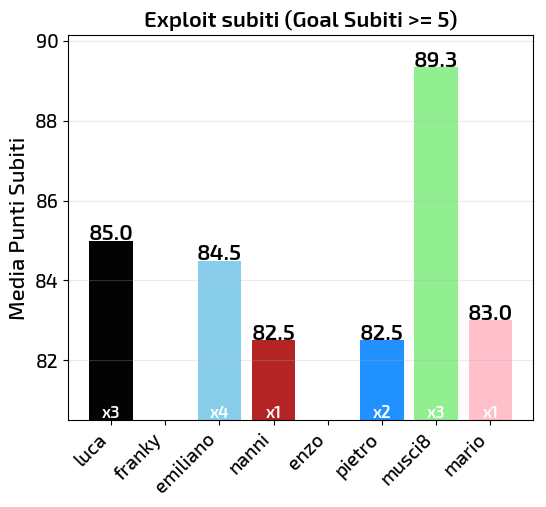

In [316]:
media, partite = print_great_opponent(82)

fig = plt.figure(figsize=(6,5))
plt.grid(which='major', axis='y', ls='-', alpha=0.25)
xlabels = Total['Team']
plt.xticks(Total.index, xlabels, rotation=45, ha='right')

colors = get_team_colors()
plt.bar(np.arange(0,8), media, color=colors, lw=0, alpha=0.99, width=0.8, label='')

min = 80.5
for i, m in enumerate(list(media)):
    va = 'top'
    offset = 0.4
    if m>0: plt.annotate(np.round(m, decimals=1), (i, m+1*offset), horizontalalignment='center', verticalalignment=va, weight='bold')
    plt.annotate('x%.0f' % partite[i], (i, min+1*offset), horizontalalignment='center', verticalalignment=va, fontsize=12, color='white', weight='bold')



plt.ylim(min, max(media)+2*offset)
plt.ylabel('Media Punti Subiti')
title = 'Exploit subiti (Goal Subiti >= 5)'
plt.title(title)
plt.show()

# [>] Andamento punti fatti/subiti

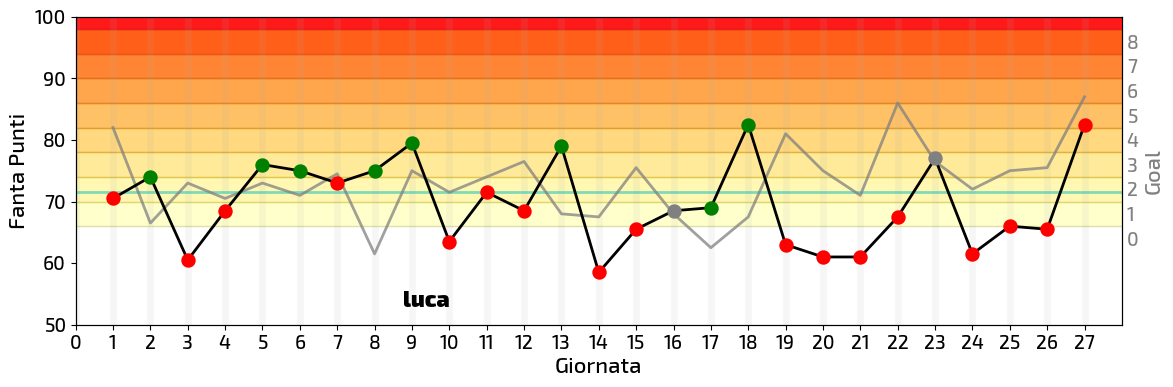

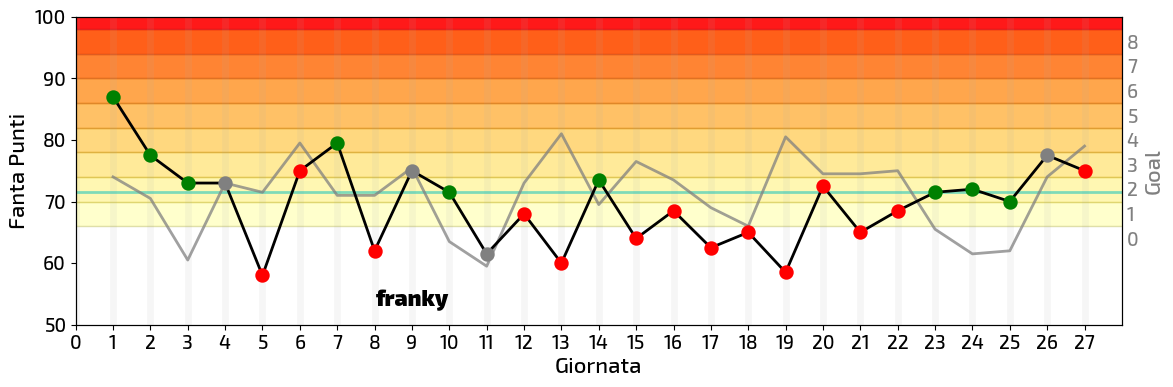

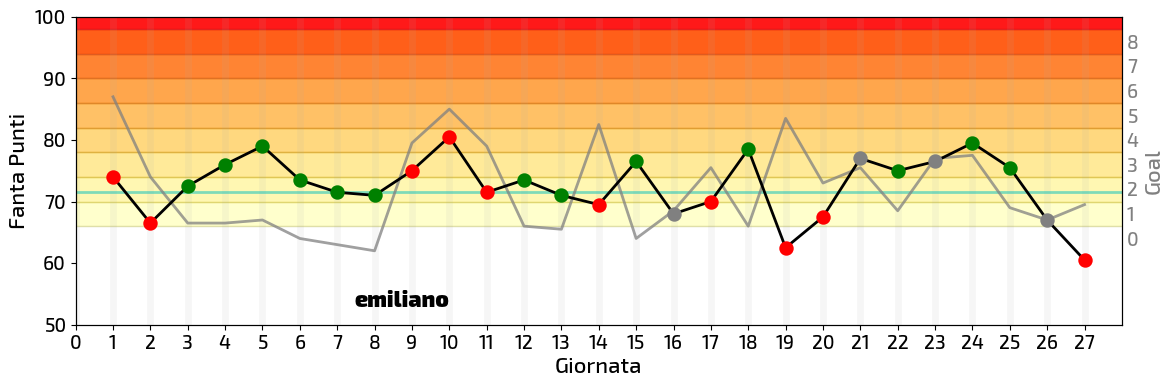

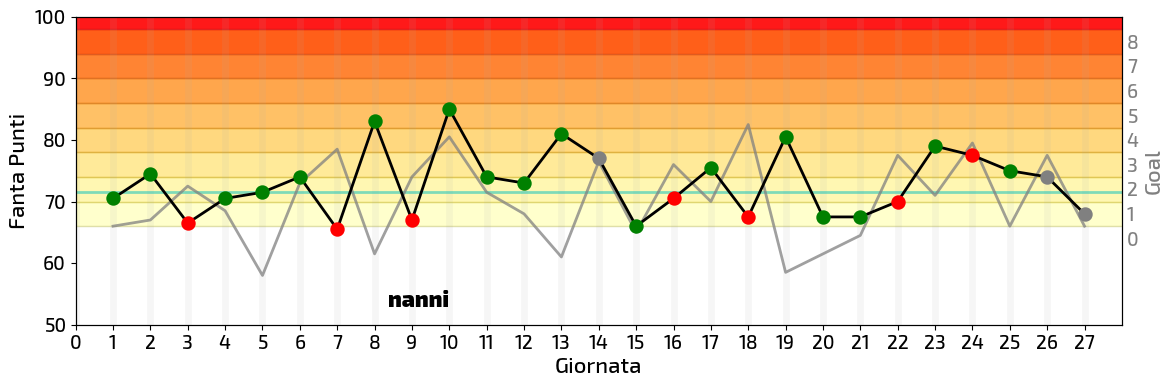

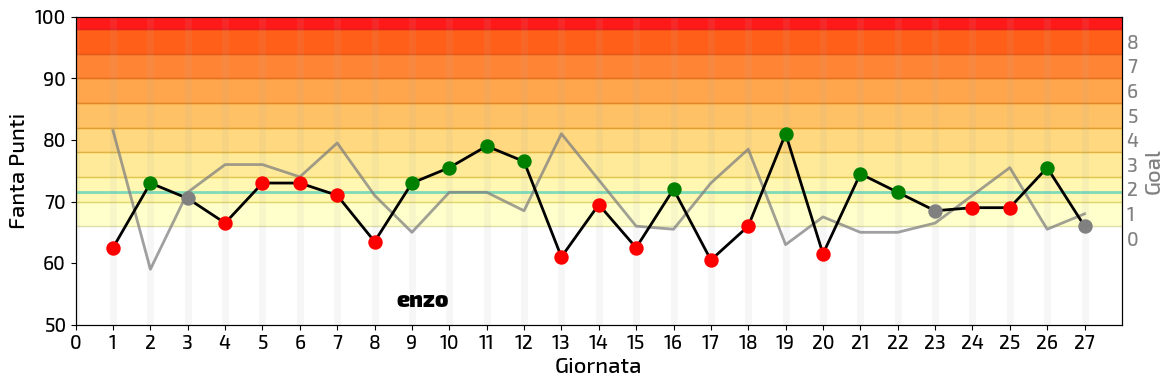

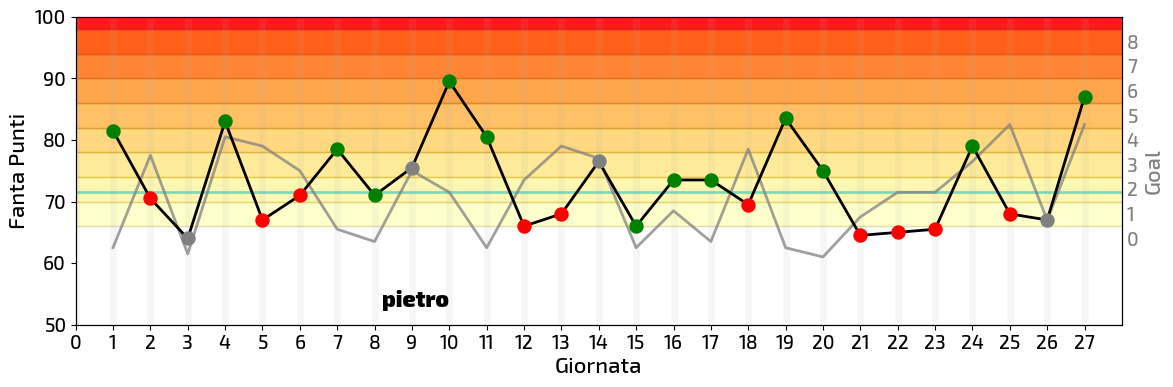

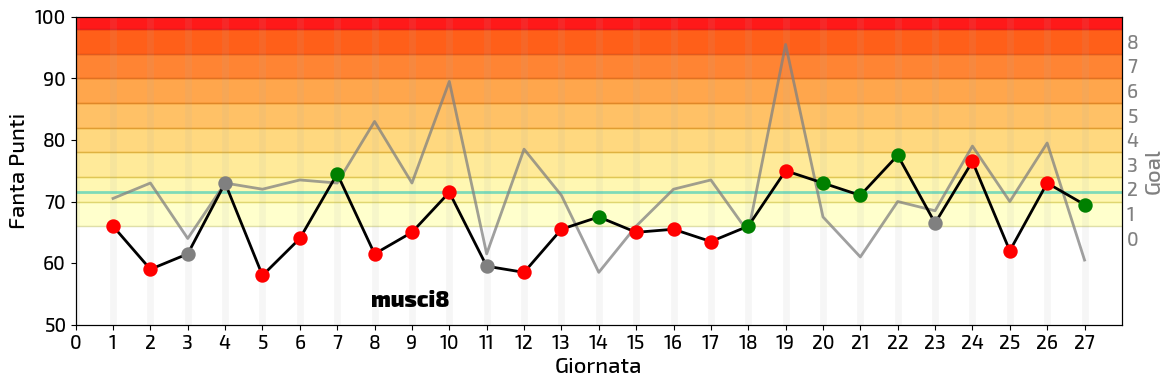

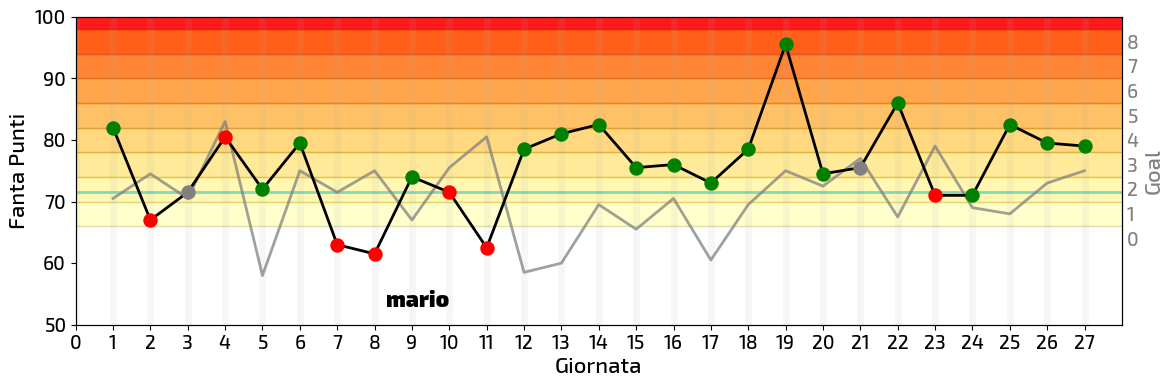

In [317]:
### Andamento per squadra ######################################################
import matplotlib.cm as cm

x = np.arange(8)
t = x

for team in Results.keys(): 
    data = Results[team]
    gg = max(data.index)
    
    fig = plt.figure(figsize=(gg*0.5,4))

    plt.hlines(goal_marks, -1000,1000, 'grey','-', linewidth=1, alpha=0.25)
    #plt.axhspan(pf_med-2*pf_std, pf_med+2*pf_std, 0, 40, color='blue', alpha=0.05, label='$2\sigma$')
    #plt.axhspan(pf_med-1*pf_std, pf_med+1*pf_std, 0, 40, color='blue', alpha=0.1, label='$1\sigma$')
    plt.hlines(pf_med,0,40, colors='c', linewidth=2, linestyles='-', alpha=0.5, label='Median')

    
    plt.fill_between([0,100], [66,66], [70,70], color=(1,1,0), alpha=0.2)
    plt.fill_between([0,100], [70,70], [74,74], color=(1,.9,0), alpha=0.3)
    plt.fill_between([0,100], [74,74], [78,78], color=(1,.8,0), alpha=0.4)
    plt.fill_between([0,100], [78,78], [82,82], color=(1,.7,0), alpha=0.5)
    plt.fill_between([0,100], [82,82], [86,86], color=(1,.6,0), alpha=0.6)
    plt.fill_between([0,100], [86,86], [90,90], color=(1,.5,0), alpha=0.7)
    plt.fill_between([0,100], [90,90], [94,94], color=(1,.4,0), alpha=0.8)
    plt.fill_between([0,100], [94,94], [98,98], color=(1,.3,0), alpha=0.9)
    plt.fill_between([0,100], [98,98], [102,102], color=(1,0,0), alpha=0.9)
    



    
    data = Results[team]
    ax = plt.plot(data.index, data['punti_subiti'], c='grey', linestyle='-', linewidth=2, alpha=.75)
    ax = plt.plot(data.index, data['punti_fatti'], c='black', linestyle='-', linewidth=2)

    #ax = plt.scatter(data.index, data['punti_subiti'], c='blue', s=data['punti_subiti'], alpha=0.1)
    data = Results[team][Results[team].esito=='S']  
    ax = plt.scatter(data.index, data['punti_fatti'], c='r', edgecolor='r', linestyle='-', linewidth=2, s=70, label='', zorder=10)
    #ax = plt.scatter(data.index, data['punti_subiti'], c='black', edgecolor='none', s=50, alpha=0.25, label='')
    data = Results[team][Results[team].esito=='P']
    ax = plt.scatter(data.index, data['punti_fatti'], c='grey', edgecolor='grey',  linestyle='-', linewidth=2, s=70, label='', zorder=10)
    #ax = plt.scatter(data.index, data['punti_subiti'], c='black', edgecolor='none', s=50, alpha=0.25, label='')
    data = Results[team][Results[team].esito=='V']
    ax = plt.scatter(data.index, data['punti_fatti'], c='g', edgecolor='g', linestyle='-', linewidth=2, s=70, label='', zorder=10)
    #ax = plt.scatter(data.index, data['punti_subiti'], c='black', edgecolor='none', s=50, alpha=0.25, label='')

    plt.xlabel('Giornata')
    plt.ylabel('Fanta Punti')
    plt.text(10,53,team, horizontalalignment='right', fontweight='1000')

    giornata=gg+1
    ymin = 50
    ymax = 100
    plt.xlim(0,giornata)
    plt.ylim(ymin, ymax)
    plt.xticks(np.arange(0,giornata))
    plt.grid(axis='x', linestyle='-', linewidth=5, alpha=0.1)
    #plt.minorticks_on()
    
    # secondary y axis
    ax2 = plt.twinx()
    goal = lambda fp: (fp-66)/4 + 0.5 
    #ymin, ymax = plt.axes.get_ylim()
    ax2.set_ylim((goal(ymin),goal(ymax)))
    ax2.set_yticks([0,1,2,3,4,5,6,7,8])
    ax2.set_ylabel('Goal')
    ax2.tick_params(axis='y', colors='grey', length=0)
    ax2.yaxis.label.set_color('grey')
    ax2.plot([],[])
  
    plt.show()

In [318]:
Tot_per_round[12].keys()

Index(['punti_fatti', 'punti_subiti', 'goal_subiti_por', 'cartellini',
       'bonus_panchina', 'mod_difesa', 'mod_fairplay', 'GF', 'GS', 'esito',
       'pti', 'Team', 'pos', 'rank', 'distacco', 'f_pos', 'f_distacco',
       'x_punti_subiti', 'x_GS', 'f_GS', 'f_close_games', 'f_stolen_games',
       'f_unlucky_opponent', 'IndiceFortuna'],
      dtype='object')

In [319]:
keys2print = ['Team', 'pos', 'rank', 'distacco', 'f_pos', 'f_distacco', 'f_GS', 'f_close_games', 'f_stolen_games', 'f_unlucky_opponent', 'IndiceFortuna']
data = Tot_per_round[11]
xxx = pd.DataFrame()
for key in keys2print:
    xxx[key] = data[key]
xxx

,Team,pos,rank,distacco,f_pos,f_distacco,f_GS,f_close_games,f_stolen_games,f_unlucky_opponent,IndiceFortuna
0,luca,7.0,7.0,12,0.0,-0.165832,-0.875605,-2,0,0,-2.041436
1,franky,4.0,5.0,9,1.0,0.213516,0.967773,0,0,0,1.681289
2,emiliano,2.0,2.0,6,0.0,0.084583,-0.506929,0,0,0,-0.422346
3,nanni,1.0,3.0,0,2.0,1.422152,1.152111,4,4,0,6.611300
4,enzo,6.0,6.0,11,0.0,-0.029970,-0.184338,-1,0,0,-0.714308
5,pietro,3.0,1.0,7,-2.0,-0.474845,0.921689,0,0,0,-0.553156
6,musci8,8.0,8.0,21,0.0,0.588056,-0.460844,2,0,0,1.127211
7,mario,5.0,4.0,11,-1.0,-0.213516,-1.013858,0,0,0,-1.727373


In [320]:
data = Tot_per_round[12]
xxx = pd.DataFrame()
for key in keys2print:
    xxx[key] = data[key]
xxx

,Team,pos,rank,distacco,f_pos,f_distacco,f_GS,f_close_games,f_stolen_games,f_unlucky_opponent,IndiceFortuna
0,luca,5.0,5.0,12,0.0,0.052928,-0.714286,-2,0,0,-1.661358
1,franky,6.0,6.0,12,0.0,0.407030,0.380952,0,0,0,0.787982
2,emiliano,2.0,3.0,6,1.0,0.440756,0.095238,0,0,0,1.035994
3,nanni,1.0,2.0,0,1.0,1.366295,1.714286,4,4,0,6.617617
4,enzo,7.0,7.0,14,0.0,0.172835,-0.809524,-1,0,0,-1.136689
5,pietro,3.0,1.0,10,-2.0,-0.460426,0.285714,0,0,0,-1.174712
6,musci8,8.0,8.0,24,0.0,0.719910,-0.428571,2,0,0,1.291339
7,mario,4.0,4.0,11,0.0,-0.052928,-0.523810,0,0,0,-0.576737
